In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, validation_curve, learning_curve, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, get_scorer_names, mean_pinball_loss, make_scorer
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from statsmodels import api as sm
import joblib
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.quantile_regression import MapieQuantileRegressor
from pprint import pprint


# FUNCTIONS

# DATAFRAMES

primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

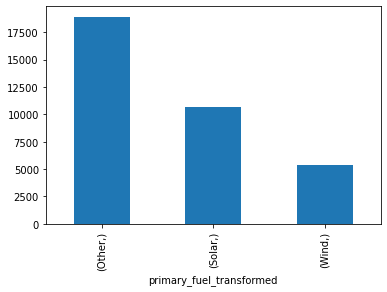

In [2]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v7_transformed_data_combined_with_nasa.csv", index_col=['index'])
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'estimated_generation_gwh_2013'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

# index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

# csv_power_plants.drop(index_set_to_delete, inplace = True)
columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        # 'estimated_generation_gwh_2013',
                        # 'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [3]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]
df_solar = df_solar[~df_solar['name'].str.contains('CSP')]
df_solar

,latitude,longitude,ANN_ALLSKY_SFC_SW_DNI_2013,ANN_ALLSKY_SFC_SW_DNI_2014,ANN_ALLSKY_SFC_SW_DNI_2015,ANN_ALLSKY_SFC_SW_DNI_2016,ANN_ALLSKY_SFC_SW_DNI_2017,ANN_ALLSKY_SFC_SW_DNI_2018,ANN_ALLSKY_SFC_SW_DNI_2019,ANN_ALLSKY_SFC_SW_DWN_2013,...,std_WS50M_RANGE_AVG_2019,name,capacity_mw,primary_fuel_transformed,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
index,,,,,,,,,,,,,,,,,,,,,
1,31.670,65.795,7.06,7.20,6.83,7.47,7.23,7.03,6.90,6.05,...,0.565,Kandahar DOG,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
2,31.623,65.792,7.06,7.20,6.83,7.47,7.23,7.03,6.90,6.05,...,0.565,Kandahar JOL,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
17,27.908,-0.317,6.21,6.06,5.75,5.70,5.90,5.78,6.28,6.15,...,0.602,Adrar,20.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
18,35.880,5.475,5.67,5.68,5.70,5.61,5.89,5.49,5.78,5.21,...,0.567,Ain Azel,20.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
20,34.532,0.804,6.08,5.86,5.93,5.87,6.06,5.72,6.25,5.34,...,0.886,Ain Sekhouna,20.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,11.700,108.900,3.99,4.55,4.80,3.99,3.59,3.99,4.58,5.23,...,0.250,Ninh Thuận CMX,168.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
34847,11.446,108.866,3.99,4.55,4.80,3.99,3.59,3.99,4.58,5.23,...,0.250,Phước Nam,330.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
34894,16.440,107.505,2.67,3.33,3.73,2.76,2.82,3.12,3.39,4.00,...,0.513,Thua Thien Hue TTC,48.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# df_solar_attempt = df_solar[df_solar['generation_gwh_2013'].isna() & df_solar['estimated_generation_gwh_2013'].notna()]
# # df_solar_attempt.loc[:,['generation_gwh_2013']] = 23.23
# # df_solar_attempt.loc[:,['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']].copy()
# df_solar.loc[df_solar_attempt.index, ['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']]

# df_solar['generation_gwh_2013'].fillna(df_solar['estimated_generation_gwh_2013'], inplace=True)

# # df_solar[df_solar['generation_gwh_2013'].isna()]

In [5]:
# df_solar_alt = df_solar[df_solar['generation_gwh_2013'].notna()]
# df_solar_alt['generation_gwh_2013'].value_counts().hist(bins=10)
# print(df_solar_alt[df_solar_alt['generation_gwh_2013'] < 20]['generation_gwh_2013'].count())
# print(df_solar_alt.loc[(df_solar_alt['generation_gwh_2013'] >= 20) & (df_solar_alt['generation_gwh_2013'] < 100)]['generation_gwh_2013'].count())


In [6]:

# df_solar_alt.loc[df_solar_alt['capacity_mw'] == (df_solar_alt['capacity_mw'].value_counts()>20)]
# indexes = df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()>20).index
# df_solar_alt['capacity_mw'].value_counts().values>20
# df_solar_alt.loc[indexes]['capacity_mw']
# df_solar_alt[df_solar_alt['capacity_mw'] == 145]
# df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)].capacity_mw
# df_solar_alt_more_than_20 = df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)]
# df_solar_alt_more_than_20['capacity_mw'].hist()

In [7]:
# utils.calculate_feature_mean_std(df_solar_alt)

In [8]:
df_solar_2013 = df_solar[df_solar['generation_gwh_2013'].notna()]
df_solar_2014 = df_solar[df_solar['generation_gwh_2014'].notna()]
df_solar_2015 = df_solar[df_solar['generation_gwh_2015'].notna()]
df_solar_2016 = df_solar[df_solar['generation_gwh_2016'].notna()]
df_solar_2017 = df_solar[df_solar['generation_gwh_2017'].notna()]
df_solar_2018 = df_solar[df_solar['generation_gwh_2018'].notna()]
# columns_delete = df_solar.columns.str.contains('WS') | df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') |  df_solar.columns.str.contains('ANN') |  df_solar.columns.str.contains('LW') |  df_solar.columns.str.contains('WS10') | df_solar.columns.str.contains('MAX')
# columns_delete = df_solar_alt.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
# columns_delete = df_solar_alt.columns.str.contains('2013') | df_solar_alt.columns.str.contains('generation_gwh_2013') | df_solar_alt.columns.str.contains('estimated_generation_gwh_2013') | df_solar_alt.columns.str.contains('WS') | df_solar_alt.columns.str.contains('name') | df_solar_alt.columns.str.contains('primary_fuel_transformed') | df_solar_alt.columns.str.contains('latitude') | df_solar_alt.columns.str.contains('longitude') | df_solar_alt.columns.str.contains('2019') | df_solar_alt.columns.str.contains('2012') | df_solar_alt.columns.str.contains('2014') | df_solar_alt.columns.str.contains('2015') | df_solar_alt.columns.str.contains('2016') | df_solar_alt.columns.str.contains('2017') | df_solar_alt.columns.str.contains('2018') 
columns_keep_2013 = df_solar_2013.columns.str.contains('2013') | df_solar_2013.columns.str.contains('capacity_mw')
columns_keep_2014 = df_solar_2014.columns.str.contains('2014') | df_solar_2014.columns.str.contains('capacity_mw')
columns_keep_2015 = df_solar_2015.columns.str.contains('2015') | df_solar_2015.columns.str.contains('capacity_mw')
columns_keep_2016 = df_solar_2016.columns.str.contains('2016') | df_solar_2016.columns.str.contains('capacity_mw')
columns_keep_2017 = df_solar_2017.columns.str.contains('2017') | df_solar_2017.columns.str.contains('capacity_mw')
columns_keep_2018 = df_solar_2018.columns.str.contains('2018') | df_solar_2018.columns.str.contains('capacity_mw')
# df_solar_2 = df_solar_alt_more_than_20.loc[:,~columns_delete]
# df_solar_2013 = df_solar_alt.loc[:,~columns_delete]
df_solar_2013 = df_solar_2013.loc[:,columns_keep_2013]
df_solar_2014 = df_solar_2014.loc[:,columns_keep_2014]
df_solar_2015 = df_solar_2015.loc[:,columns_keep_2015]
df_solar_2016 = df_solar_2016.loc[:,columns_keep_2016]
df_solar_2017 = df_solar_2017.loc[:,columns_keep_2017]
df_solar_2018 = df_solar_2018.loc[:,columns_keep_2018]
# columns_delete_2013 = df_solar_2013.columns.str.contains('WS')
df_solar_2013 = df_solar_2013.loc[:,~df_solar_2013.columns.str.contains('WS')]
df_solar_2014 = df_solar_2014.loc[:,~df_solar_2014.columns.str.contains('WS')]
df_solar_2015 = df_solar_2015.loc[:,~df_solar_2015.columns.str.contains('WS')]
df_solar_2016 = df_solar_2016.loc[:,~df_solar_2016.columns.str.contains('WS')]
df_solar_2017 = df_solar_2017.loc[:,~df_solar_2017.columns.str.contains('WS')]
df_solar_2018 = df_solar_2018.loc[:,~df_solar_2018.columns.str.contains('WS')]

In [9]:
dict_columns_2013 = {a:a.replace('_2013', '') for a in df_solar_2013.columns}
dict_columns_2014 = {a:a.replace('_2014', '') for a in df_solar_2014.columns}
dict_columns_2015 = {a:a.replace('_2015', '') for a in df_solar_2015.columns}
dict_columns_2016 = {a:a.replace('_2016', '') for a in df_solar_2016.columns}
dict_columns_2017 = {a:a.replace('_2017', '') for a in df_solar_2017.columns}
dict_columns_2018 = {a:a.replace('_2018', '') for a in df_solar_2018.columns}
df_solar_2013.rename(columns=dict_columns_2013, inplace=True)
df_solar_2014.rename(columns=dict_columns_2014, inplace=True)
df_solar_2015.rename(columns=dict_columns_2015, inplace=True)
df_solar_2016.rename(columns=dict_columns_2016, inplace=True)
df_solar_2017.rename(columns=dict_columns_2017, inplace=True)
df_solar_2018.rename(columns=dict_columns_2018, inplace=True)

In [10]:
df_solar_2018.describe()

,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLOUD_AMT_DAY,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,max_ALLSKY_SFC_SW_DNI,...,std_ALLSKY_SFC_SW_DWN,std_ALLSKY_SFC_SW_UP,std_ALLSKY_SFC_SW_UP_MAX,std_CLOUD_AMT_DAY,std_CLRSKY_SFC_SW_DNI,std_CLRSKY_SFC_SW_DWN,std_CLRSKY_SFC_SW_UP,std_T2M,capacity_mw,generation_gwh
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,5.169989,4.542576,0.695442,1.643908,52.872018,8.059989,5.754826,0.881431,13.999695,7.441699,...,1.748908,0.279878,0.363563,10.820777,1.051842,1.964541,0.303866,8.927853,11.987523,23.438099
std,1.504993,0.771645,0.248105,0.777382,14.446065,0.864580,0.389718,0.244421,4.597461,2.156493,...,0.234106,0.102544,0.210309,3.778901,0.285958,0.208851,0.111763,1.982004,32.136923,75.146772
min,2.860000,3.440000,0.160000,0.340000,22.660000,6.800000,5.160000,0.220000,0.640000,5.160000,...,0.870000,0.030000,0.021000,5.916000,0.370000,1.082000,0.012000,1.278000,1.000000,0.000000
25%,3.980000,3.780000,0.510000,1.240000,42.480000,7.480000,5.350000,0.740000,10.180000,5.760000,...,1.598000,0.224000,0.266000,8.652000,0.758000,1.811000,0.251000,7.931000,1.800000,2.098000
50%,4.650000,4.440000,0.620000,1.460000,56.100000,7.630000,5.770000,0.810000,15.120000,6.310000,...,1.743000,0.249000,0.312000,9.496000,1.062000,1.983000,0.287000,9.053000,3.500000,4.541000
75%,6.800000,5.310000,0.880000,1.820000,64.200000,8.940000,6.090000,1.070000,17.410000,9.710000,...,1.842000,0.357000,0.394000,11.704000,1.278000,2.150000,0.346000,10.076000,6.000000,9.564000
max,8.200000,6.080000,1.540000,5.530000,79.110000,10.220000,6.730000,1.650000,25.000000,11.990000,...,2.458000,0.672000,1.511000,23.167000,1.940000,2.500000,0.778000,13.194000,585.900000,1335.727000


In [11]:
df_all_concat = pd.concat([df_solar_2013,df_solar_2014,df_solar_2015,df_solar_2016,df_solar_2017,df_solar_2018])

In [12]:
df_all_concat.reset_index(drop=True, inplace = True)

In [13]:
df_all_concat['generation_gwh'].isna().sum()

0

In [14]:
# df_all_concat = df_all_concat[df_all_concat['generation_gwh'] <=30]

In [15]:
df_all_concat['capacity_factor'] = df_all_concat['generation_gwh'] / ((df_all_concat['capacity_mw'] / 1000) * 8760)
df_all_concat = df_all_concat[(df_all_concat['capacity_factor'] > 0.1) & (df_all_concat['capacity_factor'] < 1)]

In [16]:
# df_all_concat[(df_all_concat['capacity_factor'] <=0.1)]['capacity_factor'].count()

# df_all_concat[(df_all_concat['capacity_factor'] >=0.01) & (df_all_concat['capacity_factor'] < 1.00)]['capacity_factor'].count()
# df_all_concat[(df_all_concat['capacity_factor'] >=.9)]['capacity_factor'].count()
# df_all_concat[df_all_concat['capacity_factor'] <=0]
# df_all_concat[(df_all_concat['capacity_factor'] >=0.01) & (df_all_concat['capacity_factor'] < 1.00)]['capacity_factor'].count()
# df_all_concat = df_all_concat[(df_all_concat['capacity_factor'] > 0) & (df_all_concat['capacity_factor'] < 1)]
df_all_concat['capacity_factor'].describe()
# type(df_all_concat)

count    7904.000000
mean        0.203643
std         0.055285
min         0.100320
25%         0.165411
50%         0.196630
75%         0.231417
max         0.756849
Name: capacity_factor, dtype: float64

# REMOVING OUTLIERS

In [17]:
# df_all_concat.drop(df_all_concat[df_all_concat['generation_gwh'] <= 0].index, inplace=True)

In [18]:

# columns_not_consider_outliers = [
#                                     'capacity_mw',
#                                     'latitude',
#                                     'longitude',
#                                     'primary_fuel_transformed',
#                                     'code_prim_fuel_transf',
#                                     'generation_gwh_2013',
#                                     'generation_gwh_2014',
#                                     'generation_gwh_2015',
#                                     'generation_gwh_2016',
#                                     'generation_gwh_2017',
#                                     'generation_gwh_2018',
#                                     'generation_gwh_2019'
#                                 ]
# X = X.loc[:,~columns_delete]                        
df_all_concat_remove_outliers = df_all_concat[['capacity_factor', 'generation_gwh']]
iso = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso.fit_predict(df_all_concat_remove_outliers)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

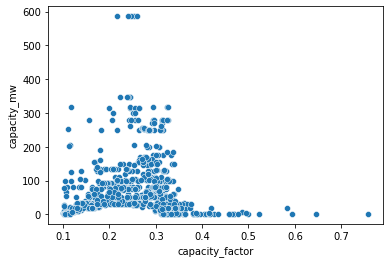

In [19]:
# df_all_concat.loc[mask,['generation_gwh', 'capacity_mw']]
sns.scatterplot(data=df_all_concat.loc[mask,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

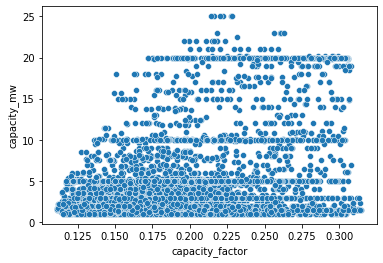

In [20]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']].drop(index_outliers, axis=0), x="capacity_factor", y="capacity_mw")


In [21]:
# df_all_concat[df_all_concat.loc[:,['name','generation_gwh', 'capacity_mw']].drop(index_outliers, axis=0)['name'].str.contains('CSP')]
# df_all_concat.loc[:,['name','generation_gwh', 'capacity_mw']].drop(index_outliers, axis=0)['name'].str.contains('CSP')
# df_all_concat.loc[~df_all_concat.drop(index_outliers, axis=0)['name'].str.contains('CSP')]
# data = df_all_concat.drop(index_outliers, axis=0).loc[df_all_concat.drop(index_outliers, axis=0)['name'].str.contains('CSP')]
# sns.scatterplot(data=data, x="generation_gwh", y="capacity_mw")
# df_all_concat.loc[:,['name','generation_gwh', 'capacity_mw']].drop(index_outliers, axis=0)['name']
# df_solar = df_solar[~df_solar['name'].str.contains('CSP')]

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

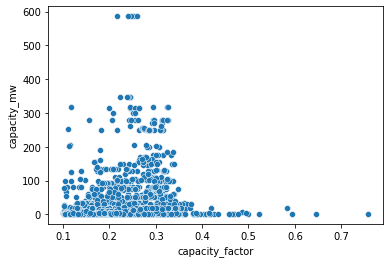

In [22]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")


In [23]:
df_all_concat.drop(index_outliers, axis=0, inplace =True)

In [24]:
df_all_concat.drop(columns=['capacity_factor'], inplace = True)

In [25]:
df_all_concat.describe()

,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLOUD_AMT_DAY,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,max_ALLSKY_SFC_SW_DNI,...,std_ALLSKY_SFC_SW_DWN,std_ALLSKY_SFC_SW_UP,std_ALLSKY_SFC_SW_UP_MAX,std_CLOUD_AMT_DAY,std_CLRSKY_SFC_SW_DNI,std_CLRSKY_SFC_SW_DWN,std_CLRSKY_SFC_SW_UP,std_T2M,capacity_mw,generation_gwh
count,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,...,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000
mean,5.411023,4.635332,0.689791,1.542728,49.831127,8.114673,5.781168,0.862127,14.378431,7.480221,...,1.732446,0.263230,0.335304,10.764801,1.027029,1.965366,0.287655,8.489014,4.520556,8.514656
std,1.431746,0.730551,0.238337,0.549088,13.308835,0.867624,0.375941,0.230018,4.180336,2.071447,...,0.247014,0.085882,0.139458,3.785356,0.281114,0.192360,0.082944,1.844439,4.751004,10.714512
min,3.030000,3.400000,0.160000,0.320000,21.160000,6.800000,5.180000,0.220000,3.150000,4.240000,...,0.505000,0.027000,0.019000,5.366000,0.370000,0.634000,0.012000,0.956000,1.000000,1.008000
25%,4.280000,3.990000,0.530000,1.260000,36.540000,7.470000,5.410000,0.740000,10.940000,5.880000,...,1.563000,0.215000,0.263000,8.461000,0.758000,1.827000,0.252000,7.515000,1.500000,2.493000
50%,4.770000,4.480000,0.620000,1.460000,54.540000,7.690000,5.790000,0.810000,15.360000,6.470000,...,1.698000,0.243000,0.326000,9.529000,1.019000,1.987000,0.280000,8.783500,3.000000,4.436500
75%,6.950000,5.310000,0.860000,1.780000,59.570000,9.030000,6.100000,1.000000,17.272500,9.562500,...,1.843000,0.321000,0.389000,11.642000,1.210000,2.119000,0.334000,9.644000,5.000000,9.202500
max,8.250000,6.570000,1.560000,5.530000,79.110000,10.220000,7.560000,1.670000,25.260000,11.990000,...,2.506000,0.672000,1.511000,24.500000,1.992000,2.508000,0.778000,13.194000,25.000000,53.529000


# STATSMODEL

In [26]:
X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_solar_2[['generation_gwh']]
y = df_all_concat['generation_gwh']

X = X.reindex(sorted(X.columns), axis=1)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.2,random_state = 0)

X_train_sm = sm.add_constant(X_train_sm)
model = sm.OLS(y_train_sm,X_train_sm)
results = model.fit()

print(f"ECM: {results.mse_resid}")

ECM: 4.650164785297619


In [ ]:
# INDIVIDUAL SIGNIFICANCE
results.pvalues.sort_values()

In [ ]:
# OVERALL SIGNIFICANCE
results.f_pvalue

In [ ]:
results.rsquared

In [ ]:
results.rsquared_adj

In [ ]:
results.summary()

In [ ]:
# Aplicamos la funcion utils.coef_summary a los results

coef_df = utils.coef_summary(results)

In [ ]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df = coef_df.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df,
                 palette="Spectral")
ax.set_title('P-values', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-value', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

In [ ]:
# SCALED

X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_solar_2[['generation_gwh']]
y = df_all_concat['generation_gwh']

min_max_scaler = MinMaxScaler()

power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()


x_scaled = min_max_scaler.fit_transform(X)
# x_scaled = power_transformer.fit_transform(X)
# x_scaled = standard_scaler.fit_transform(X)
df_X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)
df_all_concat_scaled = pd.concat([df_X_scaled,y], axis=1)
df_all_concat_scaled

In [ ]:
X = df_all_concat_scaled.drop(columns=['generation_gwh'])
# X = df_solar_2[['generation_gwh']]
y = df_all_concat_scaled['generation_gwh']

X = sm.add_constant(X)
model_scaled = sm.OLS(y,X)
results_scaled = model_scaled.fit()
# Error Cuadratico Medio de los Residuos
print(f"ECM: {results_scaled.mse_resid}")

In [ ]:
results_scaled.summary()

In [ ]:
coef_df_scaled = utils.coef_summary(results_scaled)

In [ ]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df_scaled = coef_df_scaled.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df_scaled,
                 palette="Spectral")
ax.set_title('P-valor de los regresores', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-valor', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

In [ ]:
print(f"MSE Scaled: {results_scaled.rsquared}",'vs.',f"MSE: {results.rsquared}" )
print(f"Adj MSE Scaled: {results_scaled.rsquared_adj}",'vs.',f" Adj MSE: {results.rsquared_adj}" )
print(f"p-value Scaled: {results_scaled.f_pvalue}",'vs.',f" p-value: {results.f_pvalue}" )

# CORRELATION AND MUTUAL INFORMATION SCORES

## All Best K

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


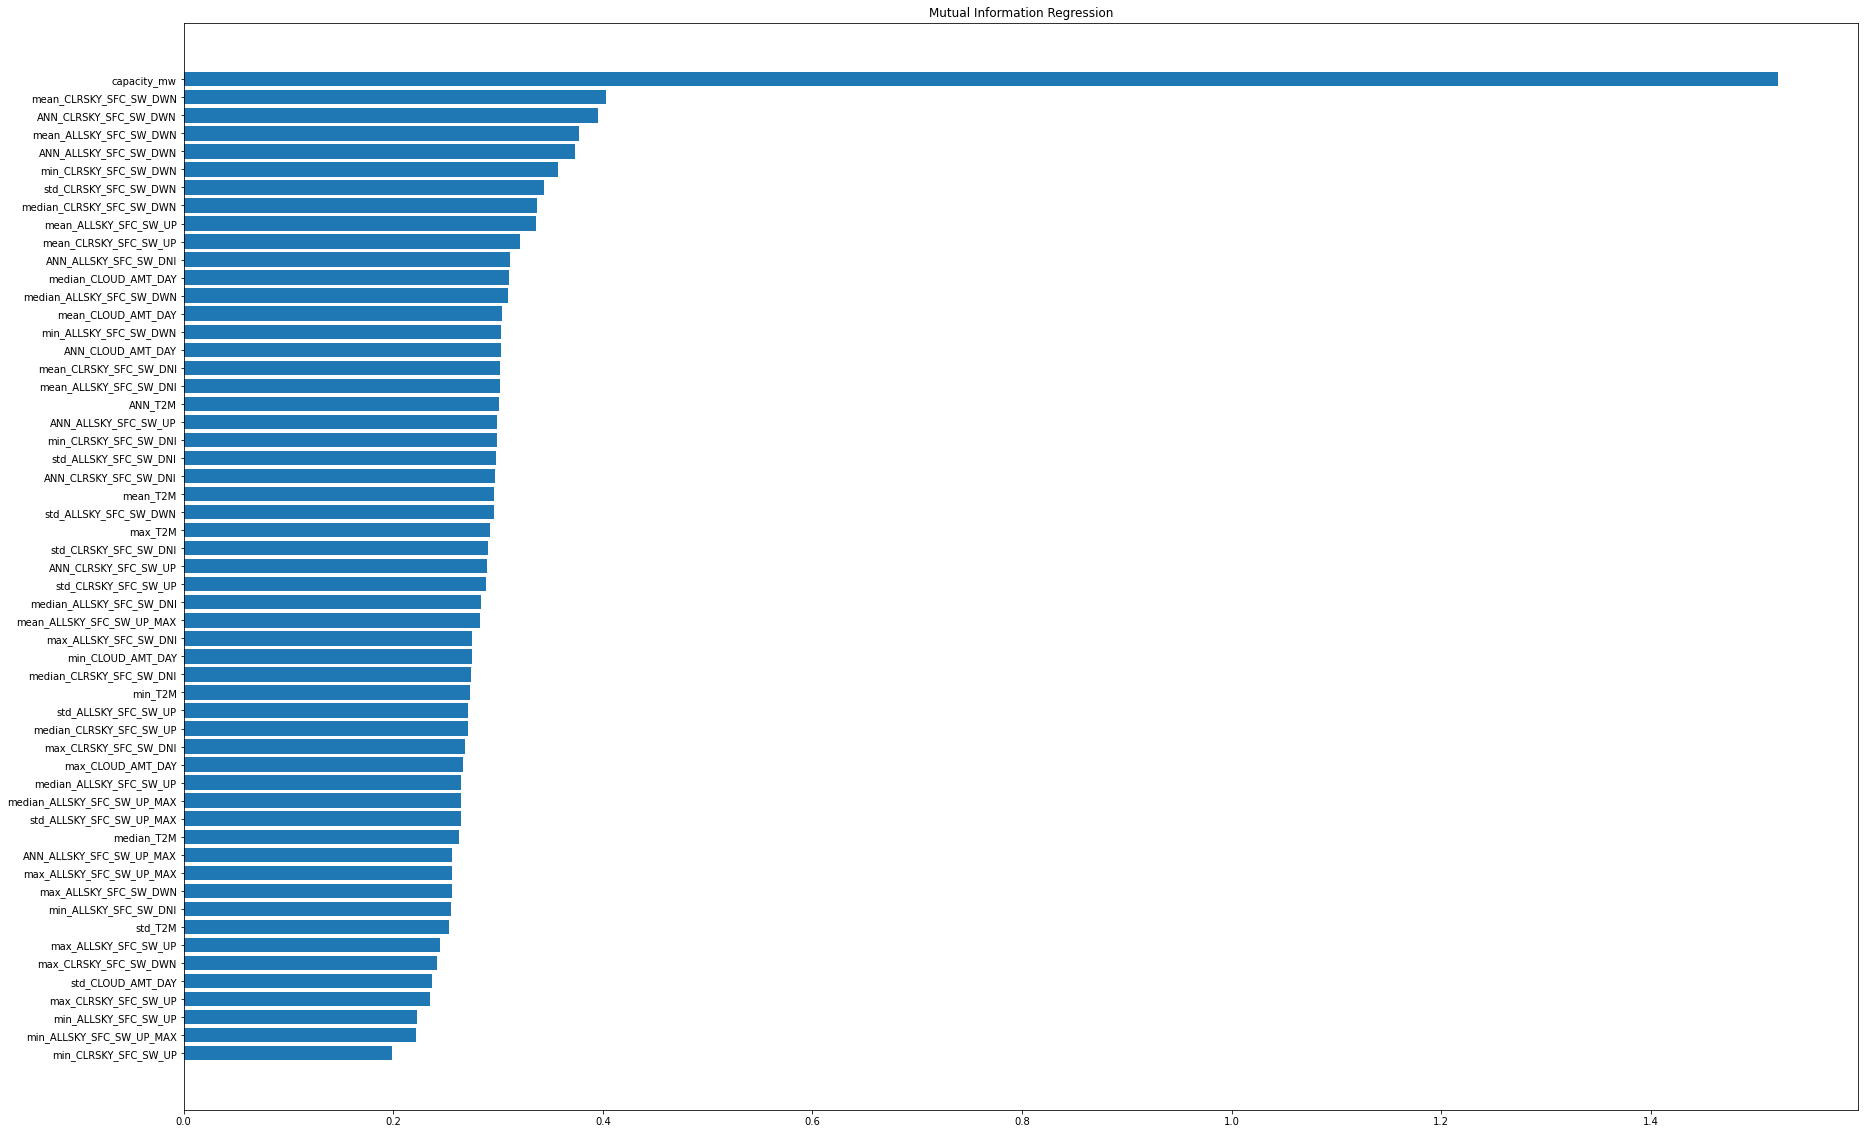

In [27]:
mi_scores = utils.make_mi_scores(df_all_concat.drop(columns=['generation_gwh']), df_all_concat[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

In [28]:
X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_all_concat[['generation_gwh']]
y = df_all_concat['generation_gwh']
# y
selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

# # df_new_X = pd.DataFrame(new_X, index=new_X.index, columns=new_X.columns)
df_all_concat_best_k_mi = pd.concat([features_df_new,y], axis=1)
# df_all_concat_best_k_mi
# selector.scores_
# utils.plot_scores(selector.scores_, "Best K")
# plt.plot(selector.scores_)
# plt.xticks(np.arange(df_all_concat.drop(columns=['generation_gwh']).columns.len), list(df_all_concat.drop(columns=['generation_gwh']).columns))

## All Linear Correlations (Pearson) > 0.30 Dataset

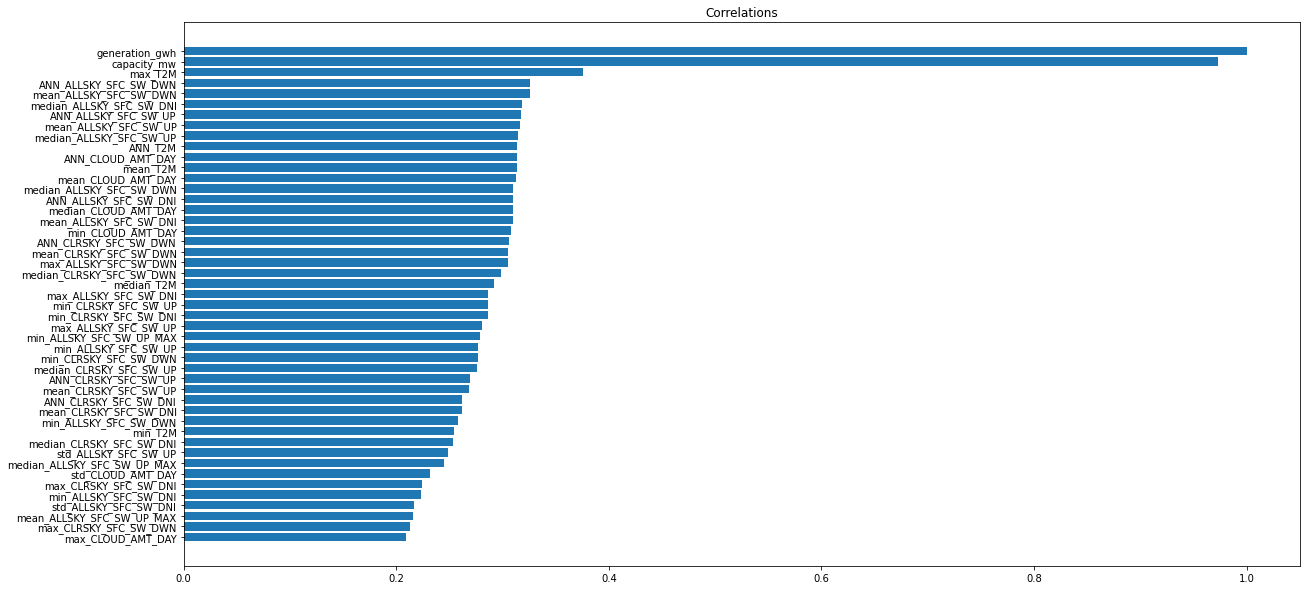

In [29]:
from matplotlib.pyplot import xlabel


# plt.bar(df_all_concat.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_all_concat.columns)
corr_matrix = df_all_concat.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations[target_correlations > .20]
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [30]:
df_all_concat_lin_corr = df_all_concat[target_correlations[target_correlations > .20].index]
df_all_concat_lin_corr

,generation_gwh,capacity_mw,max_T2M,ANN_ALLSKY_SFC_SW_DWN,mean_ALLSKY_SFC_SW_DWN,median_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_UP,mean_ALLSKY_SFC_SW_UP,median_ALLSKY_SFC_SW_UP,ANN_T2M,...,median_CLRSKY_SFC_SW_DNI,std_ALLSKY_SFC_SW_UP,median_ALLSKY_SFC_SW_UP_MAX,std_CLOUD_AMT_DAY,max_CLRSKY_SFC_SW_DNI,min_ALLSKY_SFC_SW_DNI,std_ALLSKY_SFC_SW_DNI,mean_ALLSKY_SFC_SW_UP_MAX,max_CLRSKY_SFC_SW_DWN,max_CLOUD_AMT_DAY
1,2.41461,1.9,24.59,3.98,3.976,4.290,0.52,0.519,0.565,11.73,...,7.200,0.192,0.970,7.587,8.49,2.33,1.073,0.894,7.87,71.02
2,1.52800,1.3,23.25,5.04,5.038,5.535,0.46,0.454,0.420,17.25,...,8.905,0.180,0.510,13.787,10.45,3.84,0.849,0.568,8.51,79.10
3,5.03600,3.8,24.64,3.98,3.976,4.290,0.52,0.519,0.565,11.19,...,7.200,0.192,0.970,7.587,8.49,2.33,1.073,0.894,7.87,71.02
4,2.74100,1.9,24.64,3.98,3.976,4.290,0.52,0.519,0.565,11.19,...,7.200,0.192,0.970,7.587,8.49,2.33,1.073,0.894,7.87,71.02
5,1.89400,1.0,23.25,5.74,5.738,7.820,0.87,0.873,0.905,17.25,...,9.280,0.271,1.265,9.689,10.76,5.80,1.347,1.220,8.66,40.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9655,3.55000,2.0,27.09,4.40,4.393,4.890,0.58,0.583,0.550,16.36,...,7.615,0.224,0.905,9.528,8.80,2.70,0.973,0.932,8.04,72.40
9656,9.67800,5.0,27.21,4.58,4.575,5.035,0.62,0.615,0.590,16.85,...,7.635,0.227,0.995,8.331,8.80,3.32,0.833,0.938,7.87,68.52
9657,9.02400,4.9,27.21,4.58,4.575,5.035,0.62,0.615,0.590,16.85,...,7.635,0.227,0.995,8.331,8.80,3.32,0.833,0.938,7.87,68.52
9658,9.39600,5.0,27.21,4.58,4.575,5.035,0.62,0.615,0.590,16.85,...,7.635,0.227,0.995,8.331,8.80,3.32,0.833,0.938,7.87,68.52


In [31]:
df_all_concat_lin_corr.columns

Index(['generation_gwh', 'capacity_mw', 'max_T2M', 'ANN_ALLSKY_SFC_SW_DWN',
       'mean_ALLSKY_SFC_SW_DWN', 'median_ALLSKY_SFC_SW_DNI',
       'ANN_ALLSKY_SFC_SW_UP', 'mean_ALLSKY_SFC_SW_UP',
       'median_ALLSKY_SFC_SW_UP', 'ANN_T2M', 'ANN_CLOUD_AMT_DAY', 'mean_T2M',
       'mean_CLOUD_AMT_DAY', 'median_ALLSKY_SFC_SW_DWN',
       'ANN_ALLSKY_SFC_SW_DNI', 'median_CLOUD_AMT_DAY',
       'mean_ALLSKY_SFC_SW_DNI', 'min_CLOUD_AMT_DAY', 'ANN_CLRSKY_SFC_SW_DWN',
       'mean_CLRSKY_SFC_SW_DWN', 'max_ALLSKY_SFC_SW_DWN',
       'median_CLRSKY_SFC_SW_DWN', 'median_T2M', 'max_ALLSKY_SFC_SW_DNI',
       'min_CLRSKY_SFC_SW_UP', 'min_CLRSKY_SFC_SW_DNI', 'max_ALLSKY_SFC_SW_UP',
       'min_ALLSKY_SFC_SW_UP_MAX', 'min_ALLSKY_SFC_SW_UP',
       'min_CLRSKY_SFC_SW_DWN', 'median_CLRSKY_SFC_SW_UP',
       'ANN_CLRSKY_SFC_SW_UP', 'mean_CLRSKY_SFC_SW_UP',
       'ANN_CLRSKY_SFC_SW_DNI', 'mean_CLRSKY_SFC_SW_DNI',
       'min_ALLSKY_SFC_SW_DWN', 'min_T2M', 'median_CLRSKY_SFC_SW_DNI',
       'std_ALLSKY_SFC

## Annual Dataset

In [32]:
corr_matrix

,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLOUD_AMT_DAY,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,max_ALLSKY_SFC_SW_DNI,...,std_ALLSKY_SFC_SW_DWN,std_ALLSKY_SFC_SW_UP,std_ALLSKY_SFC_SW_UP_MAX,std_CLOUD_AMT_DAY,std_CLRSKY_SFC_SW_DNI,std_CLRSKY_SFC_SW_DWN,std_CLRSKY_SFC_SW_UP,std_T2M,capacity_mw,generation_gwh
ANN_ALLSKY_SFC_SW_DNI,1.000000,0.968917,0.828607,0.178773,0.982006,0.906638,0.861323,0.658483,0.659006,0.918921,...,0.498435,0.595479,0.054751,0.536536,0.295726,0.130362,0.352020,0.594477,0.222165,0.309621
ANN_ALLSKY_SFC_SW_DWN,0.968917,1.000000,0.783900,0.091319,0.954087,0.865449,0.947367,0.602763,0.777967,0.844834,...,0.341609,0.501644,0.048460,0.474872,0.131709,0.340838,0.246949,0.679731,0.244738,0.326257
ANN_ALLSKY_SFC_SW_UP,0.828607,0.783900,1.000000,0.573116,0.790839,0.819221,0.716769,0.962682,0.438144,0.770714,...,0.453289,0.829694,0.427369,0.402625,0.215220,0.037877,0.701399,0.225169,0.242404,0.317417
ANN_ALLSKY_SFC_SW_UP_MAX,0.178773,0.091319,0.573116,1.000000,0.120990,0.309797,0.046224,0.709317,0.231849,0.233171,...,0.265699,0.704767,0.955812,0.121174,0.226374,0.309236,0.832124,0.347574,0.042493,0.063413
ANN_CLOUD_AMT_DAY,0.982006,0.954087,0.790839,0.120990,1.000000,0.816444,0.828638,0.607773,0.711510,0.875232,...,0.447230,0.550013,0.004095,0.495543,0.206367,0.204035,0.296194,0.601180,0.232188,0.313189
ANN_CLRSKY_SFC_SW_DNI,0.906638,0.865449,0.819221,0.309797,0.816444,1.000000,0.816697,0.710123,0.433616,0.882679,...,0.523939,0.620316,0.176151,0.538406,0.441138,0.061321,0.449688,0.478609,0.172872,0.261470
ANN_CLRSKY_SFC_SW_DWN,0.861323,0.947367,0.716769,0.046224,0.828638,0.816697,1.000000,0.563958,0.775855,0.697299,...,0.118225,0.369225,0.124610,0.336340,0.050622,0.506855,0.153188,0.677123,0.236100,0.305721
ANN_CLRSKY_SFC_SW_UP,0.658483,0.602763,0.962682,0.709317,0.607773,0.710123,0.563958,1.000000,0.249087,0.628031,...,0.405418,0.849160,0.570546,0.316111,0.186505,0.051165,0.798655,0.023386,0.208391,0.269459
ANN_T2M,0.659006,0.777967,0.438144,0.231849,0.711510,0.433616,0.775855,0.249087,1.000000,0.487664,...,0.007214,0.183807,0.320516,0.268617,0.258145,0.691612,0.073729,0.716797,0.272660,0.313348
max_ALLSKY_SFC_SW_DNI,0.918921,0.844834,0.770714,0.233171,0.875232,0.882679,0.697299,0.628031,0.487664,1.000000,...,0.740320,0.683592,0.155754,0.751383,0.557789,0.132695,0.430653,0.503995,0.197926,0.286457


In [33]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()

columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('ANN') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_annual = df_all_concat.loc[:,columns_keep]

corr_matrix = df_all_concat_annual.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
# df_all_concat_annual.drop(columns=to_drop, inplace=True)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


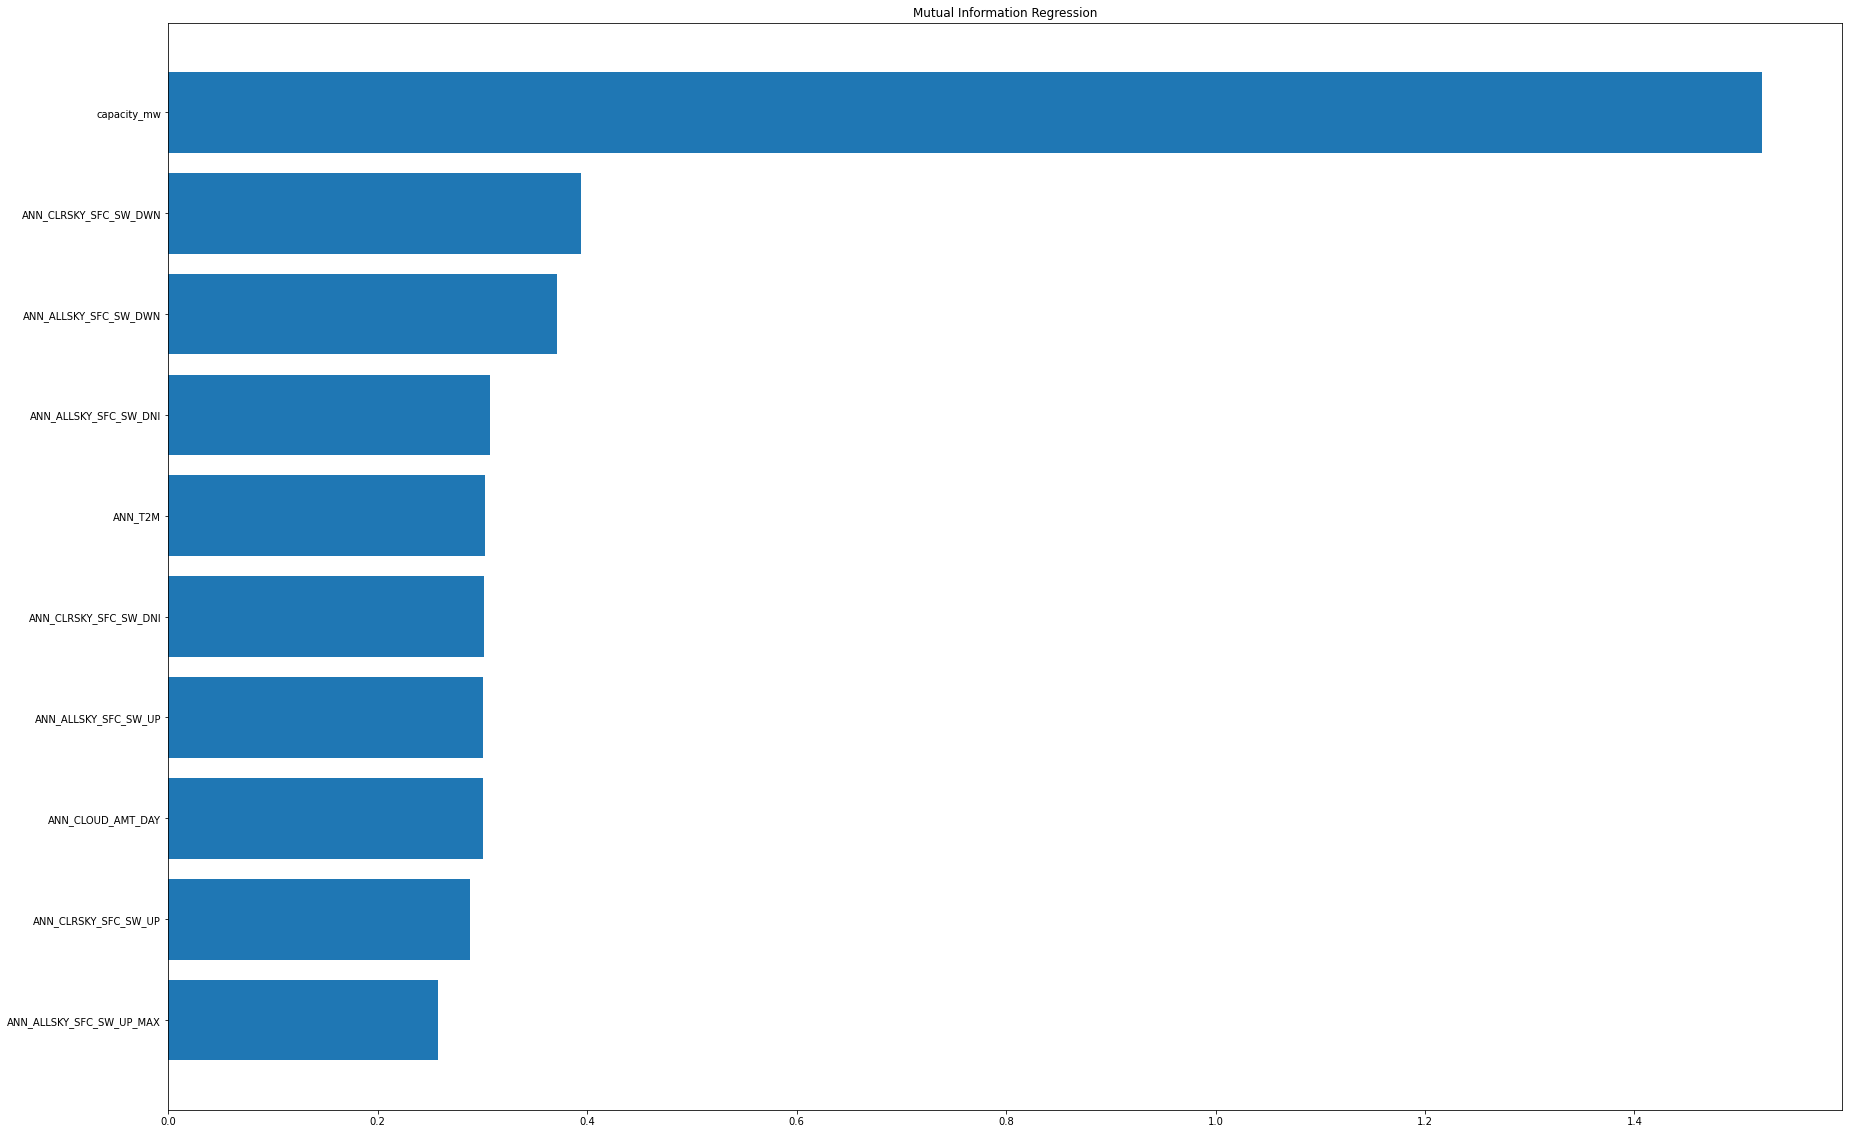

In [34]:
mi_scores = utils.make_mi_scores(df_all_concat_annual.drop(columns=['generation_gwh']), df_all_concat_annual[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

## Annual Best K (Mutual Information) Dataset 

In [35]:
X = df_all_concat_annual.drop(columns=['generation_gwh'])
# X = df_all_concat_annual[['generation_gwh']]
y = df_all_concat_annual['generation_gwh']
# y
selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

# # df_new_X = pd.DataFrame(new_X, index=new_X.index, columns=new_X.columns)
df_all_concat_annual_best_k_mi = pd.concat([features_df_new,y], axis=1)
# df_all_concat_annual_best_k_mi
# selector.scores_
# utils.plot_scores(selector.scores_, "Best K")
# plt.plot(selector.scores_)
# plt.xticks(np.arange(df_all_concat_annual.drop(columns=['generation_gwh']).columns.len), list(df_all_concat_annual.drop(columns=['generation_gwh']).columns))

In [36]:
df_all_concat_annual_best_k_mi

,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLOUD_AMT_DAY,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,capacity_mw,generation_gwh
1,4.28,3.98,0.52,1.23,58.62,7.24,5.40,0.72,11.73,1.9,2.41461
2,5.35,5.04,0.46,0.96,54.92,8.75,6.18,0.55,17.25,1.3,1.52800
3,4.28,3.98,0.52,1.23,58.62,7.24,5.40,0.72,11.19,3.8,5.03600
4,4.28,3.98,0.52,1.23,58.62,7.24,5.40,0.72,11.19,1.9,2.74100
5,7.79,5.74,0.87,2.07,27.02,9.30,6.28,0.97,17.25,1.0,1.89400
...,...,...,...,...,...,...,...,...,...,...,...
9655,4.53,4.40,0.58,1.22,58.46,7.61,5.84,0.78,16.36,2.0,3.55000
9656,4.81,4.58,0.62,1.31,53.99,7.60,5.84,0.79,16.85,5.0,9.67800
9657,4.81,4.58,0.62,1.31,53.99,7.60,5.84,0.79,16.85,4.9,9.02400
9658,4.81,4.58,0.62,1.31,53.99,7.60,5.84,0.79,16.85,5.0,9.39600


## Annual Linear Correlations (Pearson) > 0.30 Dataset

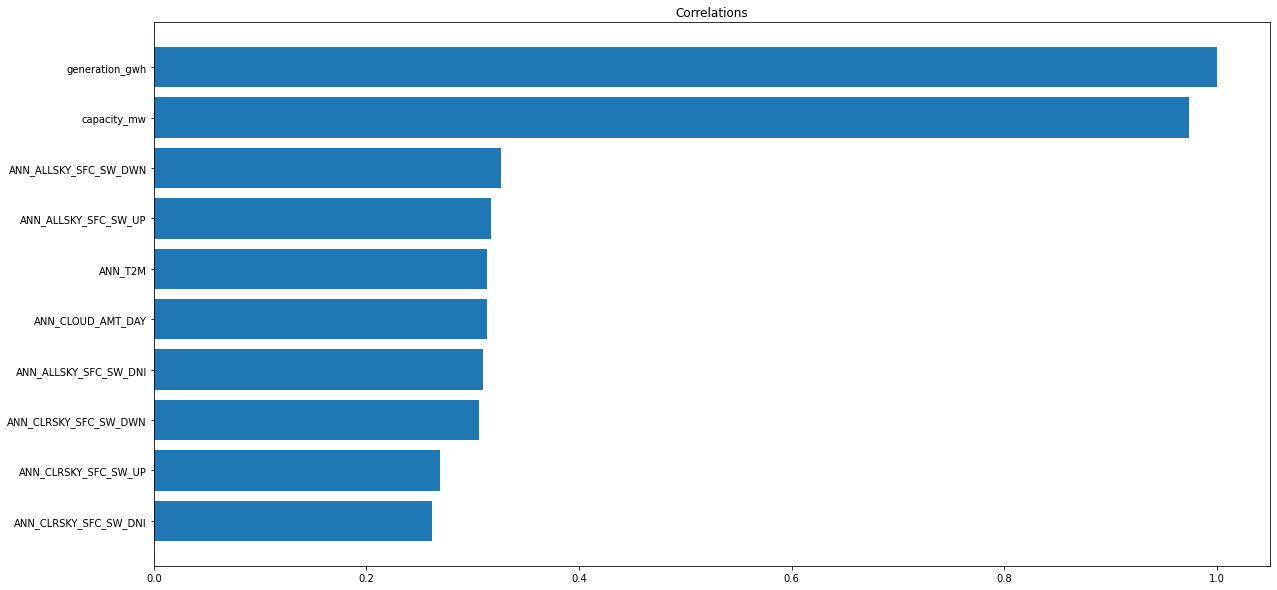

In [37]:
from matplotlib.pyplot import xlabel


# plt.bar(df_all_concat_annual.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_all_concat_annual.columns)
corr_matrix = df_all_concat_annual.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations[target_correlations > .30]
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [38]:
df_all_concat_annual_lin_corr = df_all_concat_annual[target_correlations[target_correlations > .20].index]
df_all_concat_annual_lin_corr

,generation_gwh,capacity_mw,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_T2M,ANN_CLOUD_AMT_DAY,ANN_ALLSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_CLRSKY_SFC_SW_DNI
1,2.41461,1.9,3.98,0.52,11.73,58.62,4.28,5.40,0.72,7.24
2,1.52800,1.3,5.04,0.46,17.25,54.92,5.35,6.18,0.55,8.75
3,5.03600,3.8,3.98,0.52,11.19,58.62,4.28,5.40,0.72,7.24
4,2.74100,1.9,3.98,0.52,11.19,58.62,4.28,5.40,0.72,7.24
5,1.89400,1.0,5.74,0.87,17.25,27.02,7.79,6.28,0.97,9.30
...,...,...,...,...,...,...,...,...,...,...
9655,3.55000,2.0,4.40,0.58,16.36,58.46,4.53,5.84,0.78,7.61
9656,9.67800,5.0,4.58,0.62,16.85,53.99,4.81,5.84,0.79,7.60
9657,9.02400,4.9,4.58,0.62,16.85,53.99,4.81,5.84,0.79,7.60
9658,9.39600,5.0,4.58,0.62,16.85,53.99,4.81,5.84,0.79,7.60


In [39]:
# g = sns.PairGrid(df_all_concat_annual_lin_corr)
# g.map(sns.scatterplot)

# sns.pairplot(df_all_concat_annual_lin_corr)

## Capacity and Shortwave Down features

In [40]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('SW_DWN') | df_all_concat.columns.str.contains('capacity_mw') | df_all_concat.columns.str.contains('capacity_factor')
df_all_concat_capacity_shortwave_down = df_all_concat.loc[:,columns_keep]
df_all_concat_capacity_shortwave_down
# sns.pairplot(df_all_concat_capacity_shortwave_down)

,ANN_ALLSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_DWN,max_ALLSKY_SFC_SW_DWN,max_CLRSKY_SFC_SW_DWN,mean_ALLSKY_SFC_SW_DWN,mean_CLRSKY_SFC_SW_DWN,median_ALLSKY_SFC_SW_DWN,median_CLRSKY_SFC_SW_DWN,min_ALLSKY_SFC_SW_DWN,min_CLRSKY_SFC_SW_DWN,std_ALLSKY_SFC_SW_DWN,std_CLRSKY_SFC_SW_DWN,capacity_mw,generation_gwh
1,3.98,5.40,5.94,7.87,3.976,5.392,4.230,5.665,1.51,2.40,1.621,2.010,1.9,2.41461
2,5.04,6.18,7.08,8.51,5.038,6.175,5.230,6.375,3.21,3.50,1.267,1.822,1.3,1.52800
3,3.98,5.40,5.94,7.87,3.976,5.392,4.230,5.665,1.51,2.40,1.621,2.010,3.8,5.03600
4,3.98,5.40,5.94,7.87,3.976,5.392,4.230,5.665,1.51,2.40,1.621,2.010,1.9,2.74100
5,5.74,6.28,8.01,8.66,5.738,6.274,5.985,6.460,3.19,3.52,1.776,1.880,1.0,1.89400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9655,4.40,5.84,6.68,8.04,4.393,5.831,4.360,6.015,1.94,3.16,1.582,1.794,2.0,3.55000
9656,4.58,5.84,6.73,7.87,4.575,5.833,4.585,6.070,2.20,3.24,1.554,1.726,5.0,9.67800
9657,4.58,5.84,6.73,7.87,4.575,5.833,4.585,6.070,2.20,3.24,1.554,1.726,4.9,9.02400
9658,4.58,5.84,6.73,7.87,4.575,5.833,4.585,6.070,2.20,3.24,1.554,1.726,5.0,9.39600


In [41]:
# sns.pairplot(df_all_concat_capacity_shortwave_down)

## Only Capacity

In [42]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_only_capacity = df_all_concat.loc[:,columns_keep]
df_all_concat_only_capacity

,capacity_mw,generation_gwh
1,1.9,2.41461
2,1.3,1.52800
3,3.8,5.03600
4,1.9,2.74100
5,1.0,1.89400
...,...,...
9655,2.0,3.55000
9656,5.0,9.67800
9657,4.9,9.02400
9658,5.0,9.39600


## Only Capacity and Capacity Factor

In [43]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('capacity_mw') | df_all_concat.columns.str.contains('capacity_factor')
df_all_concat_only_capacity_and_factor = df_all_concat.loc[:,columns_keep]
df_all_concat_only_capacity_and_factor

,capacity_mw,generation_gwh
1,1.9,2.41461
2,1.3,1.52800
3,3.8,5.03600
4,1.9,2.74100
5,1.0,1.89400
...,...,...
9655,2.0,3.55000
9656,5.0,9.67800
9657,4.9,9.02400
9658,5.0,9.39600


In [ ]:
pd.qcut(df_all_concat['capacity_mw'], 4)

In [ ]:
category = pd.qcut(df_all_concat['capacity_mw'], 4).cat.codes.rename('category')
# category = pd.cut(df_all_concat['capacity_mw'], 6).cat.codes.rename('category')
df_all_concat_w_category = pd.concat([df_all_concat, category], axis=1)

In [ ]:
category.value_counts()

In [ ]:
sns.pairplot(df_all_concat_w_category, hue='category')

# X AND Y

In [44]:
dataframes_dict_X_y = {
    'df_all_concat_annual_lin_corr' : {},
    'df_all_concat_annual_best_k_mi': {},
    'df_all_concat_lin_corr': {},
    'df_all_concat_best_k_mi': {},
    'df_all_concat': {},
    'df_all_concat_capacity_shortwave_down': {},
    'df_all_concat_only_capacity': {},
    'df_all_concat_only_capacity_and_factor': {}
}


In [45]:
iso_df_all_concat_annual_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_lin_corr.fit_predict(df_all_concat_annual_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_lin_corr[mask].index
df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_annual_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_annual_lin_corr[['capacity_mw']]
y = df_all_concat_annual_lin_corr['generation_gwh']



dataframes_dict_X_y['df_all_concat_annual_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_lin_corr']['y'] = y

/tmp/ipykernel_340/2987193366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [46]:
iso_df_all_concat_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_lin_corr.fit_predict(df_all_concat_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_lin_corr[mask].index
df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_lin_corr[['capacity_mw']]
y = df_all_concat_lin_corr['generation_gwh']

dataframes_dict_X_y['df_all_concat_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_lin_corr']['y'] = y

/tmp/ipykernel_340/2728832043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [47]:
# X = df_all_concat_w_category.drop(columns=['generation_gwh'])
# # X = df_solar_2[['capacity_mw']]
# y = df_all_concat_w_category['generation_gwh']

In [48]:
iso_df_all_concat_annual_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_best_k_mi.fit_predict(df_all_concat_annual_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_best_k_mi[mask].index
df_all_concat_annual_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_annual_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_solar_2[['capacity_mw']]
y = df_all_concat_annual_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y'] = y

In [49]:
iso_df_all_concat_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_best_k_mi.fit_predict(df_all_concat_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_best_k_mi[mask].index
df_all_concat_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_solar_2[['capacity_mw']]
y = df_all_concat_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_best_k_mi']['y'] = y

In [50]:
iso_df_all_concat = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat.fit_predict(df_all_concat)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index
df_all_concat.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat[['capacity_mw']]
y = df_all_concat['generation_gwh']


dataframes_dict_X_y['df_all_concat']['X'] = X
dataframes_dict_X_y['df_all_concat']['y'] = y

In [51]:
X = df_all_concat_only_capacity[['capacity_mw']]
X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_only_capacity[['capacity_mw']]
y = df_all_concat_only_capacity['generation_gwh']

dataframes_dict_X_y['df_all_concat_only_capacity']['X'] = X
dataframes_dict_X_y['df_all_concat_only_capacity']['y'] = y

In [52]:
X = df_all_concat_only_capacity_and_factor[['capacity_mw']]
X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_only_capacity_and_factor[['capacity_mw']]
y = df_all_concat_only_capacity_and_factor['generation_gwh']

dataframes_dict_X_y['df_all_concat_only_capacity_and_factor']['X'] = X
dataframes_dict_X_y['df_all_concat_only_capacity_and_factor']['y'] = y

In [53]:
iso_df_all_concat_capacity_shortwave_down = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_capacity_shortwave_down.fit_predict(df_all_concat_capacity_shortwave_down)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_capacity_shortwave_down[mask].index
df_all_concat_capacity_shortwave_down.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_capacity_shortwave_down.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_capacity_shortwave_down[['capacity_mw']]
y = df_all_concat_capacity_shortwave_down['generation_gwh']


dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X'] = X
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y'] = y

/tmp/ipykernel_340/2596333196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_capacity_shortwave_down.drop(index_outliers, axis=0, inplace =True)


In [54]:
# X = df_all_concat_scaled.drop(columns=['generation_gwh'])
# # X = df_all_concat_scaled[['capacity_mw']]
# y = df_all_concat_scaled['generation_gwh']

In [55]:
# del dataframes_dict_X_y['df_all_concat_only_capacity']
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down'] = {}
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X'] = X
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y'] = y

In [56]:
for i, df_X_y in dataframes_dict_X_y.items():
    list_train_test_split = train_test_split(df_X_y['X'], df_X_y['y'], test_size=0.2,random_state = 0)
    dataframes_dict_X_y[i]['X_train'] = list_train_test_split[0]
    dataframes_dict_X_y[i]['X_test'] = list_train_test_split[1]
    dataframes_dict_X_y[i]['y_train'] = list_train_test_split[2]
    dataframes_dict_X_y[i]['y_test'] = list_train_test_split[3]

In [57]:
# X_all = X_all.reindex(sorted(X.columns), axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2,random_state = 0)

# DECISION TREE REGRESSOR

df_all_concat_annual_lin_corr best_tree_size: 100
df_all_concat_annual_best_k_mi best_tree_size: 100
df_all_concat_lin_corr best_tree_size: 80
df_all_concat_best_k_mi best_tree_size: 50
df_all_concat best_tree_size: 50
df_all_concat_capacity_shortwave_down best_tree_size: 50
df_all_concat_only_capacity best_tree_size: 50
df_all_concat_only_capacity_and_factor best_tree_size: 50


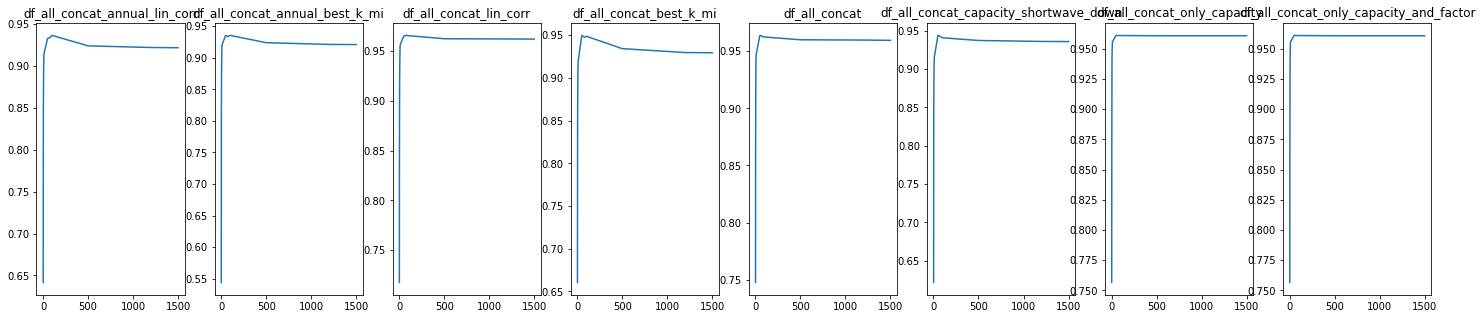

In [58]:
candidate_max_leaf_nodes = [2, 3, 4, 5, 7, 10, 50, 80, 100, 500, 1200, 1500]
# candidate_max_leaf_nodes = [2, 3, 4, 5, 7, 10]

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(25,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_tree("regression",node, df_X_y['X_train'], df_X_y['X_test'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_max_leaf_nodes}
    best_tree_size = max(results, key=results.get)
    print(f'{k} best_tree_size: {best_tree_size}')
    dataframes_dict_X_y[k]['best_tree_size'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])

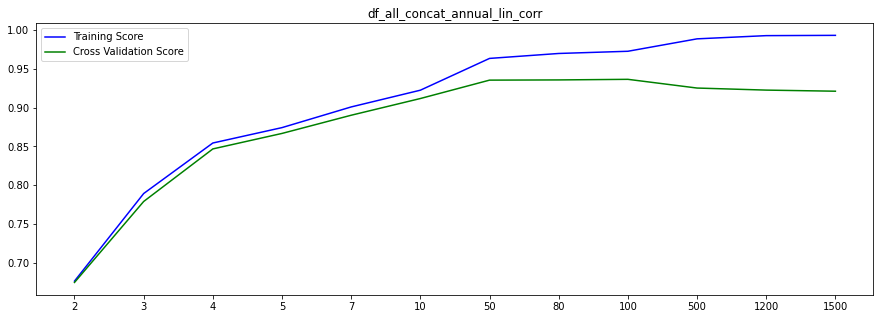

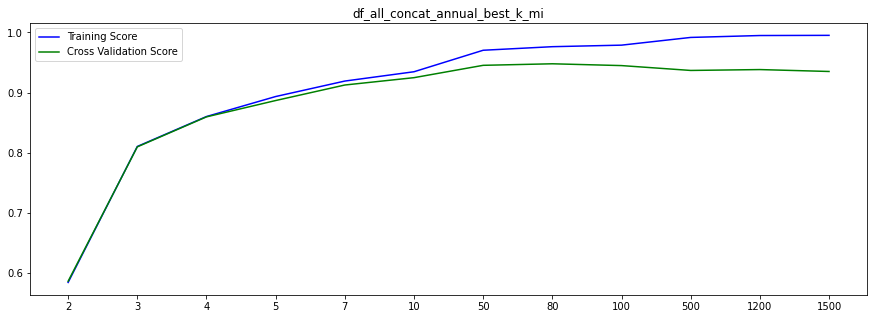

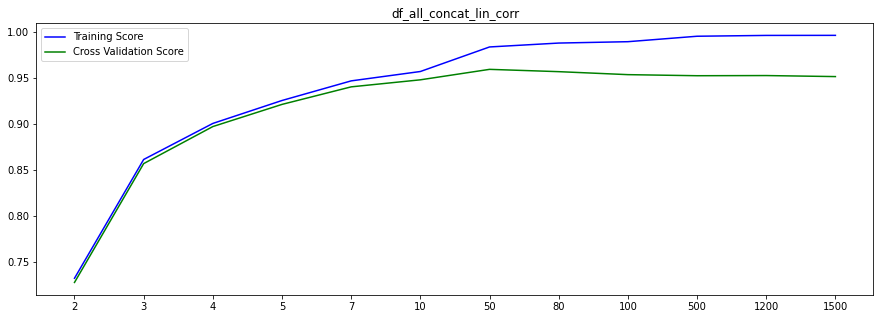

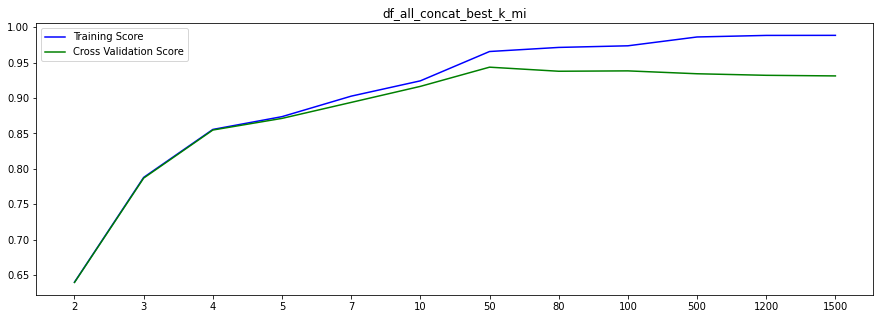

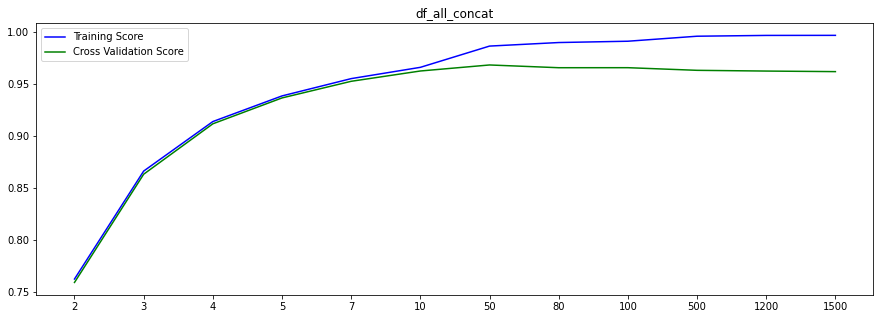

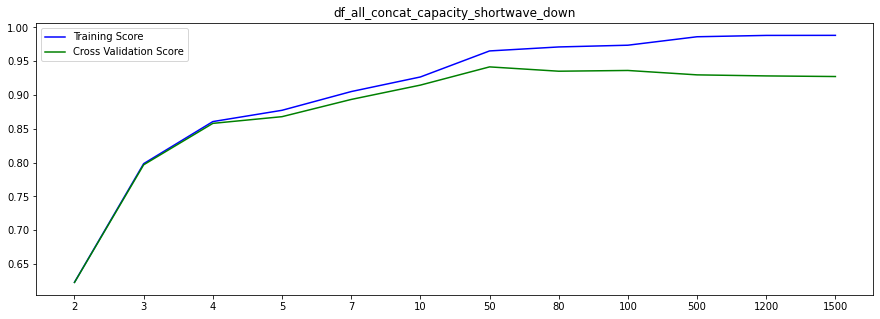

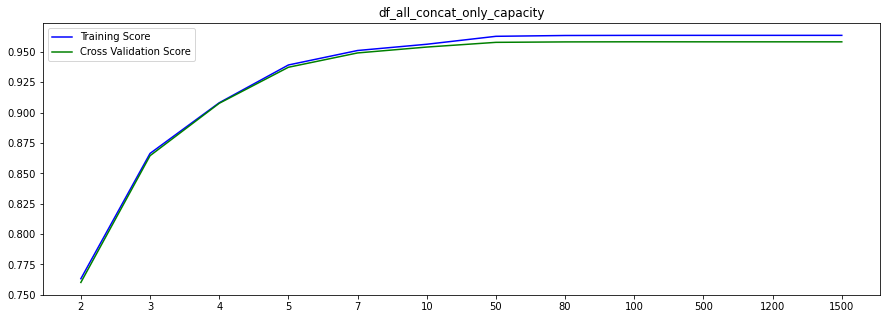

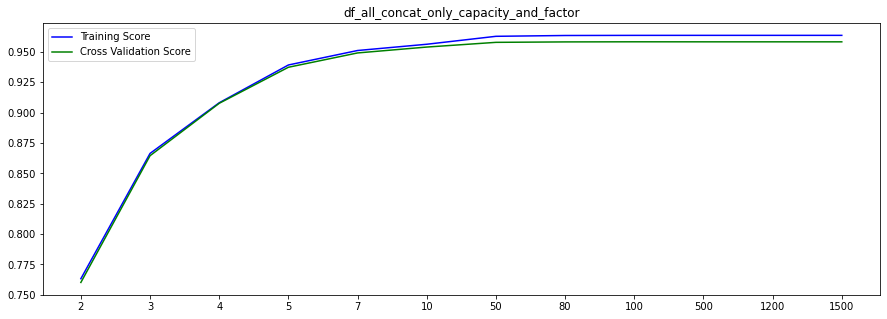

In [59]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, DecisionTreeRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'max_leaf_nodes', np.array(candidate_max_leaf_nodes))

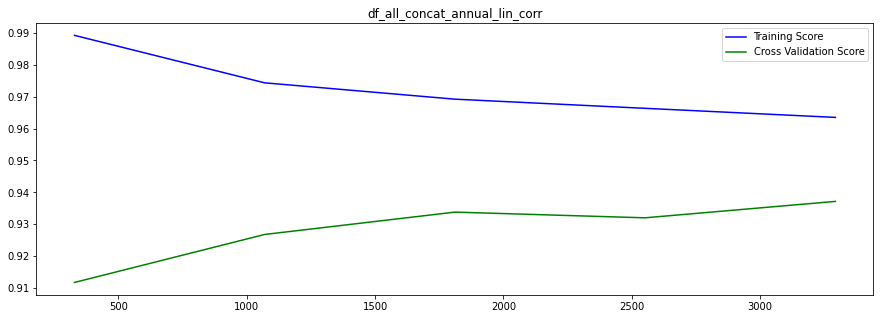

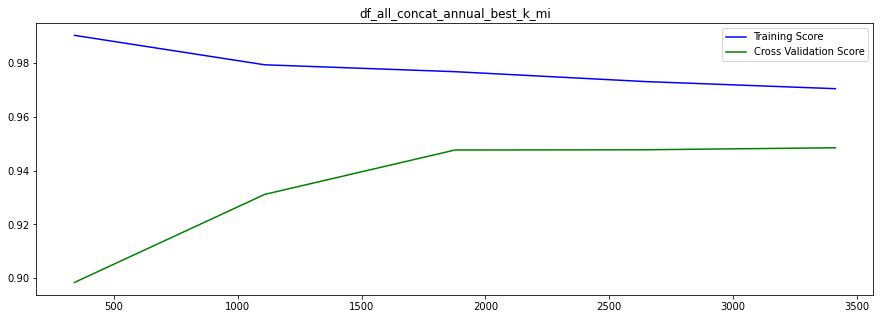

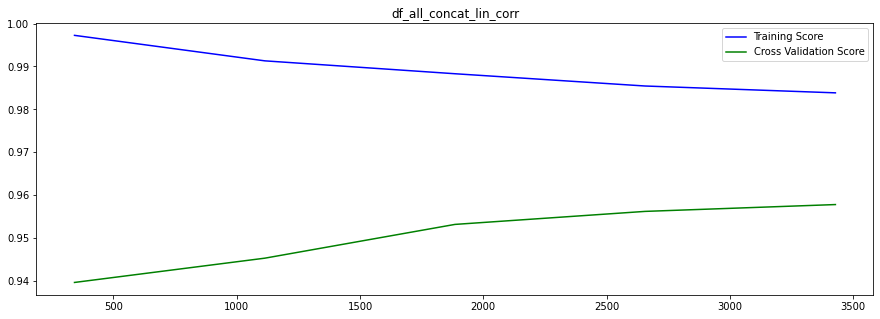

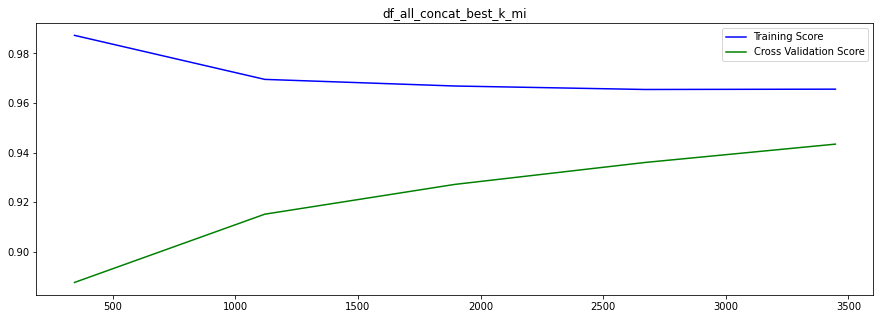

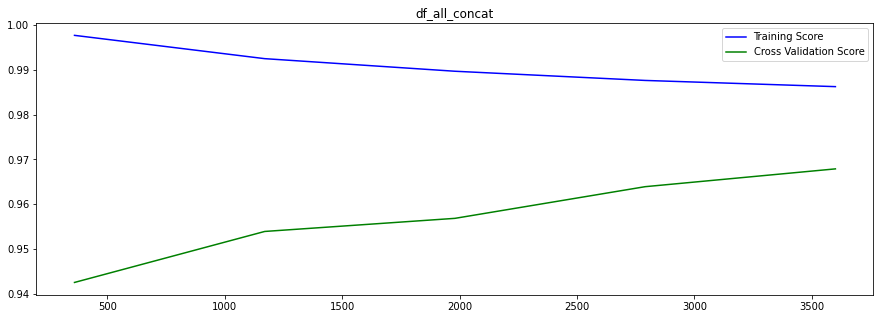

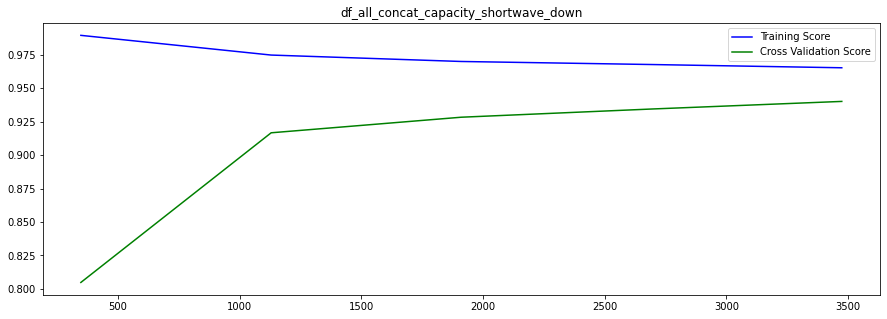

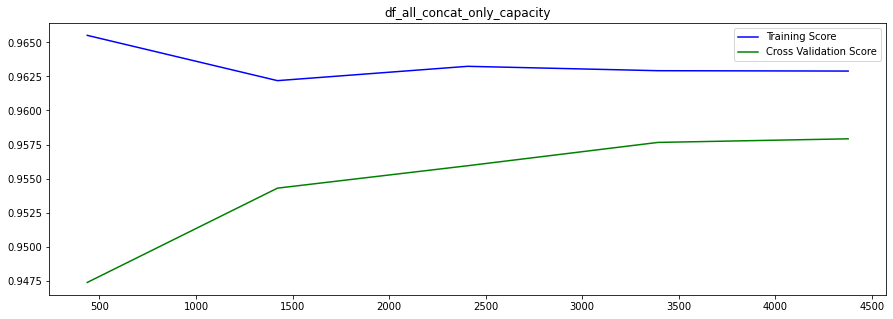

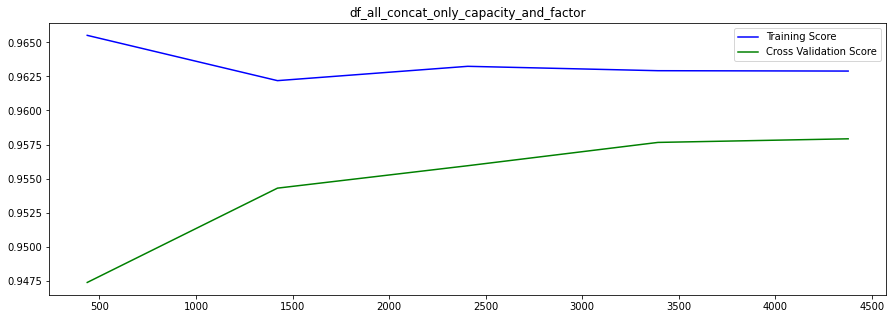

In [60]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, DecisionTreeRegressor(max_leaf_nodes=50),df_X_y['X_train'], df_X_y['y_train'])

In [61]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], DecisionTreeRegressor(max_leaf_nodes=50), k)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9354738892562754, 'test_mean_squared_error': 0.8753521789014712, 'test_mean_absolute_error': 0.5831801041993753, 'test_root_mean_squared_error': 0.927497669675154}
df_all_concat_annual_best_k_mi
{'test_r2': 0.9451815766103072, 'test_mean_squared_error': 1.1195331641414028, 'test_mean_absolute_error': 0.6320312903474102, 'test_root_mean_squared_error': 1.0559066681183942}
df_all_concat_lin_corr
{'test_r2': 0.9577332775828602, 'test_mean_squared_error': 3.115435746351579, 'test_mean_absolute_error': 0.8705691677515223, 'test_root_mean_squared_error': 1.7630073814988585}
df_all_concat_best_k_mi
{'test_r2': 0.9438058560956994, 'test_mean_squared_error': 0.9010437022949095, 'test_mean_absolute_error': 0.5985713142051725, 'test_root_mean_squared_error': 0.9468077146019305}
df_all_concat
{'test_r2': 0.9680905018213751, 'test_mean_squared_error': 3.1670660442452436, 'test_mean_absolute_error': 0.9086112268702706, 'test_root_mean_squared_error': 1.776

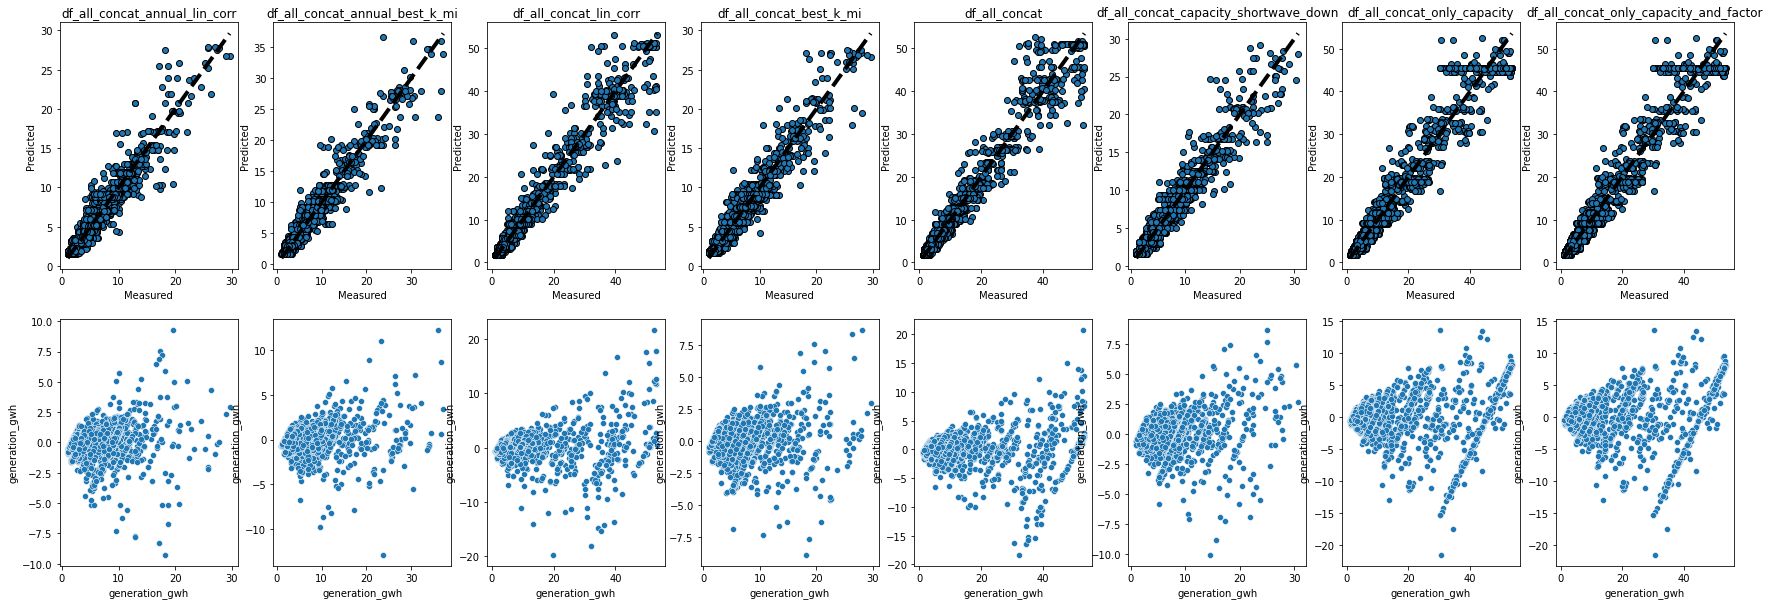

In [62]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(DecisionTreeRegressor(max_leaf_nodes=50), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [63]:
# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(max_leaf_nodes = 50)

# Fit model
tree_model.fit(dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y_train'])
y_pred = tree_model.predict(dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X_test'])

# RANDOM FOREST REGRESSOR

In [64]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [65]:

# rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid, n_iter = 20, cv=5, verbose = 2, n_jobs=4)

In [66]:
rf_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=410, max_leaf_nodes=500, min_samples_leaf=65, min_samples_split=30, n_estimators=90; total time=   6.5s
[CV] END bootstrap=True, max_depth=410, max_leaf_nodes=500, min_samples_leaf=65, min_samples_split=30, n_estimators=90; total time=   6.3s
[CV] END bootstrap=True, max_depth=410, max_leaf_nodes=500, min_samples_leaf=65, min_samples_split=30, n_estimators=90; total time=   6.4s
[CV] END bootstrap=True, max_depth=410, max_leaf_nodes=500, min_samples_leaf=65, min_samples_split=30, n_estimators=90; total time=   6.3s
[CV] END bootstrap=True, max_depth=410, max_leaf_nodes=500, min_samples_leaf=65, min_samples_split=30, n_estimators=90; total time=   7.0s
[CV] END bootstrap=False, max_depth=110, max_leaf_nodes=130, min_samples_leaf=15, min_samples_split=40, n_estimators=100; total time=  16.6s
[CV] END bootstrap=False, max_depth=110, max_leaf_nodes=130, min_samples_leaf=15, min_samples_split=40

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
                                                      230, 240, 250, 260, 270,
                                                      280, 290, 300, ...],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, 120, 130, 140,
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=2)

In [67]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=180, max_leaf_nodes=240, min_samples_leaf=15,
                      min_samples_split=30, n_estimators=50)

In [68]:
rf_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

0.9699451398145725

In [69]:
rf_model = RandomForestRegressor(max_depth=180, max_leaf_nodes=240, min_samples_leaf=15,
                      min_samples_split=30, n_estimators=50)
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):

    # results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_model, k)
    # print(df_X_y)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9435154010865802, 'test_mean_squared_error': 0.7653364398642906, 'test_mean_absolute_error': 0.5334438847461946, 'test_root_mean_squared_error': 0.8722873512837994}
df_all_concat_annual_best_k_mi
{'test_r2': 0.9504562967437383, 'test_mean_squared_error': 1.02497500160306, 'test_mean_absolute_error': 0.5871112706870906, 'test_root_mean_squared_error': 1.0071231827619733}
df_all_concat_lin_corr
{'test_r2': 0.9700988747134224, 'test_mean_squared_error': 2.2060709412341266, 'test_mean_absolute_error': 0.7561723517310981, 'test_root_mean_squared_error': 1.4830053195753146}
df_all_concat_best_k_mi
{'test_r2': 0.9430251724073303, 'test_mean_squared_error': 0.9136137566860505, 'test_mean_absolute_error': 0.577448340207072, 'test_root_mean_squared_error': 0.9529583137369924}
df_all_concat
{'test_r2': 0.9751550611126699, 'test_mean_squared_error': 2.464095011204871, 'test_mean_absolute_error': 0.8045910880420006, 'test_root_mean_squared_error': 1.56637

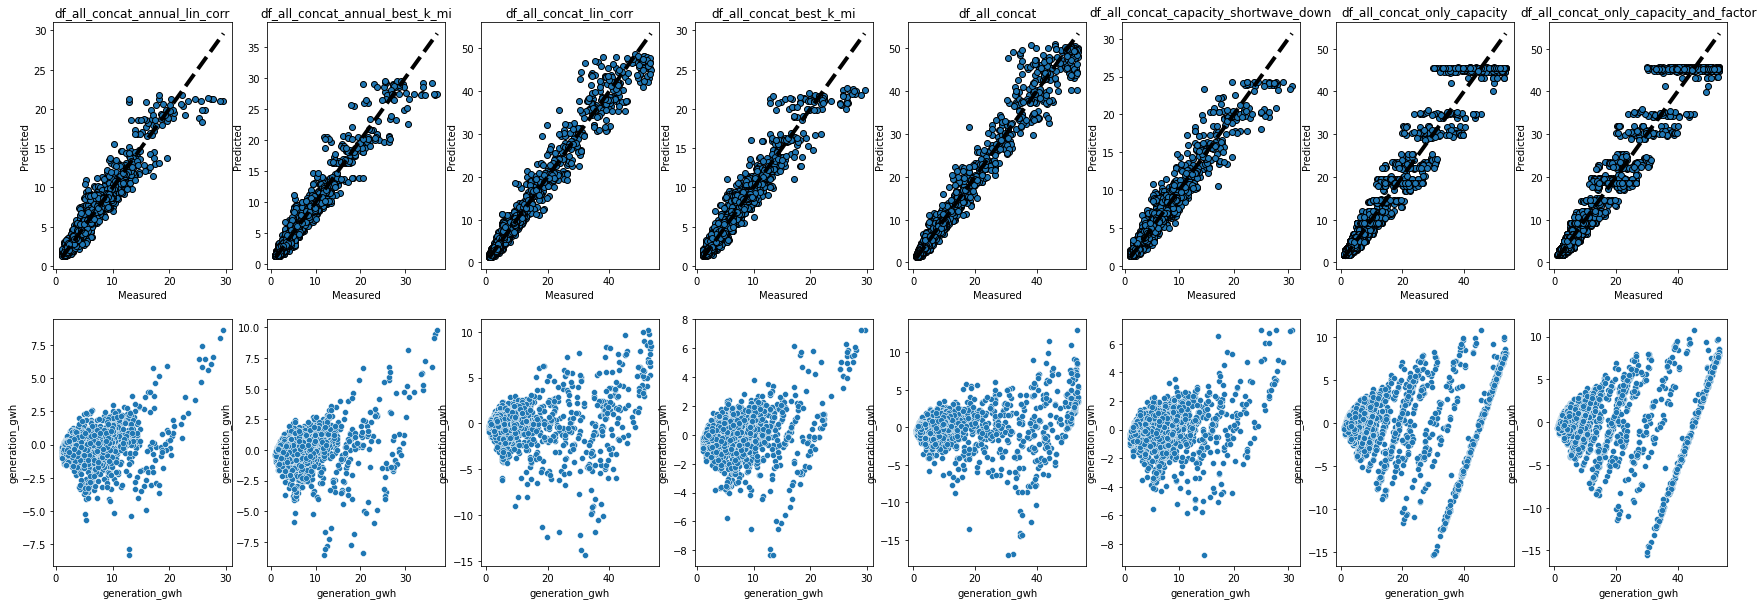

In [71]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(rf_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()
    
    residuals = df_X_y['y_train'] - predicted
    dataframes_dict_X_y[k]['predictions'] = predicted
    dataframes_dict_X_y[k]['residuals'] = residuals
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

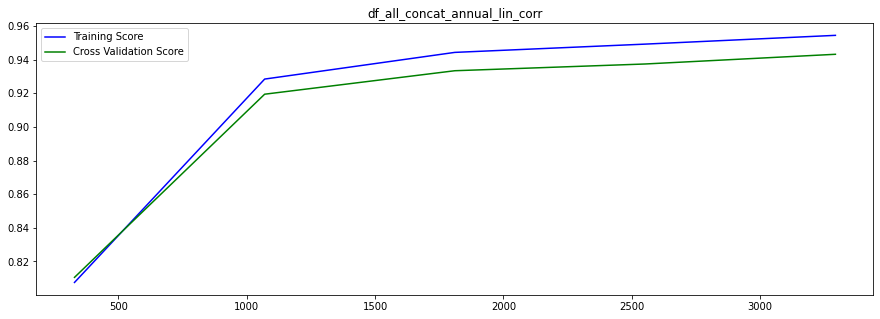

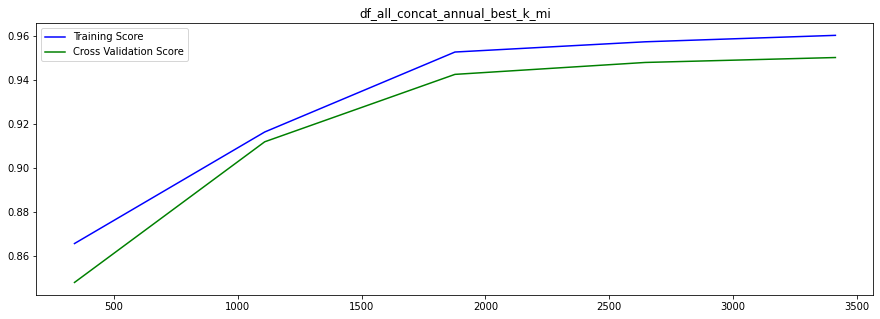

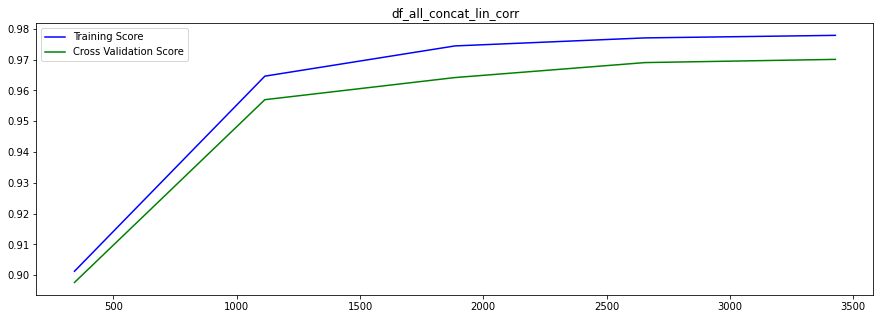

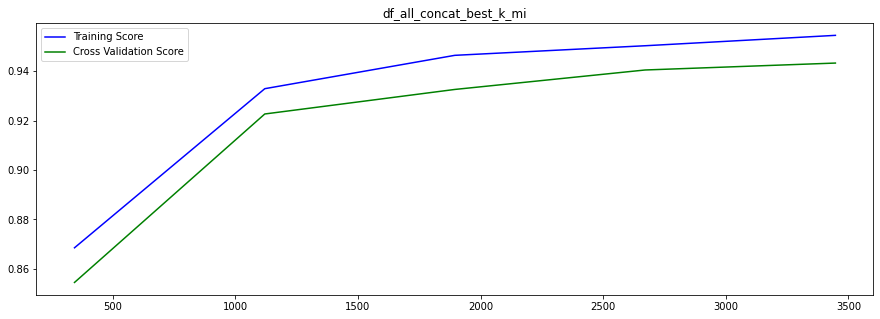

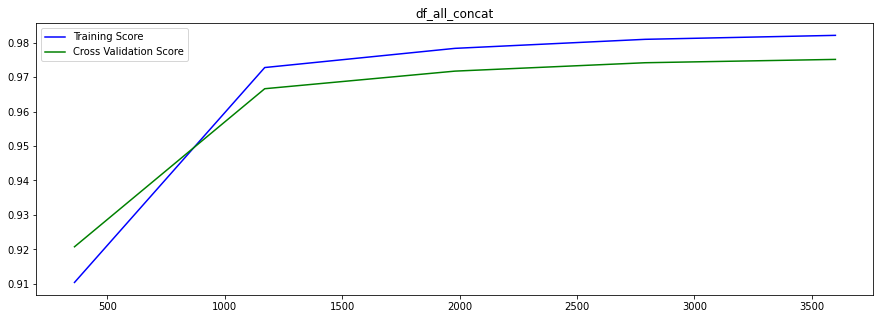

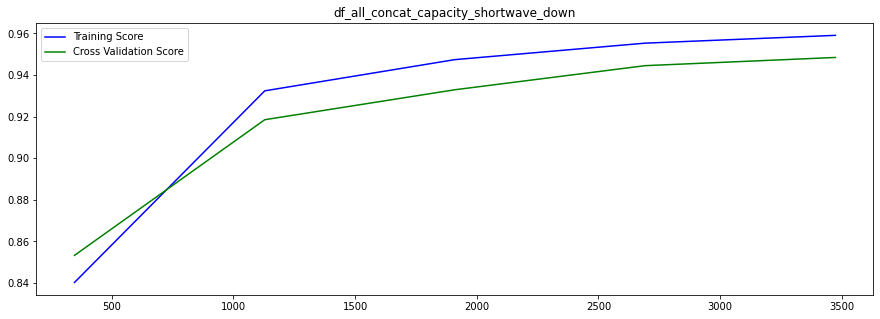

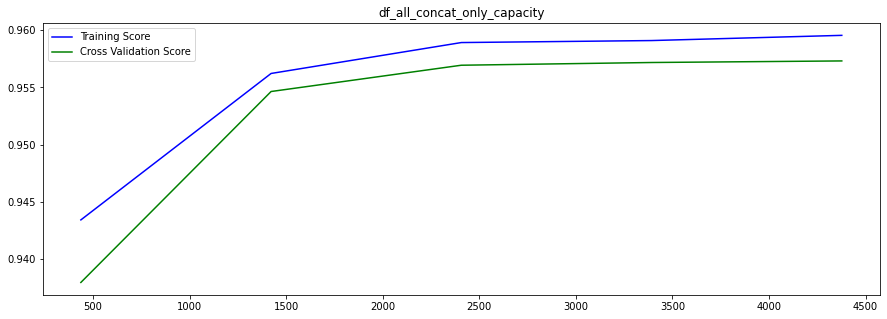

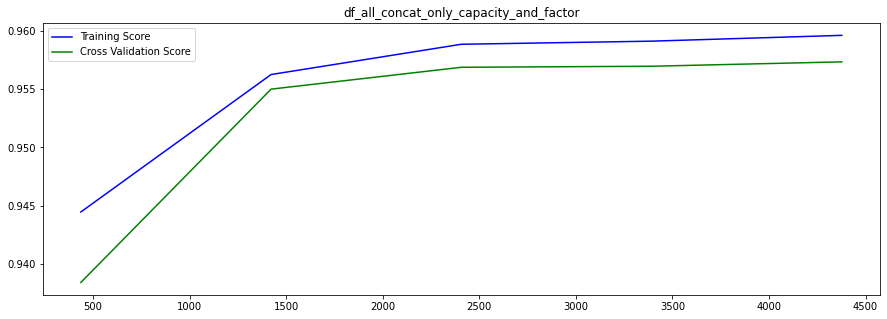

In [72]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, rf_model,df_X_y['X_train'], df_X_y['y_train'])

In [ ]:
residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['residuals'].reset_index()
residuals_original = dataframes_dict_X_y['df_all_concat_lin_corr']['residuals']

In [ ]:
residuals

In [ ]:
residuals['index']

In [ ]:
residuals[residuals == residuals.quantile(.05, interpolation='lower')].values

In [ ]:
lowq = float(residuals['generation_gwh'][residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.05, interpolation='lower')].values)
lowq_index_pred = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.05, interpolation='lower')].index
lowq_index = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.05, interpolation='lower')]['index']

In [ ]:
higq = float(residuals['generation_gwh'][residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.95, interpolation='lower')].values)
higq_index_pred = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.95, interpolation='lower')].index
higq_index = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.95, interpolation='lower')]['index']

In [ ]:
print(lowq) 
print(higq) 
print(lowq_index) 
print(higq_index) 
print(lowq_index_pred) 
print(higq_index_pred) 

In [ ]:
# dataframes_dict_X_y['df_all_concat_lin_corr']['predictions'][lowq_index]

In [ ]:
# Generating the error distribution
# resid_oob = dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'] - rf_model_2.oob_prediction_
# residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['residuals']
# residuals[residuals == residuals.quantile(.05, interpolation='lower')]
# 50% interval
lowq = residuals.quantile(0.05)
# lowq_index = residuals.index(residuals.quantile(0.05))
higq = residuals.quantile(0.95)
# higq_index = residuals.index(residuals.quantile(0.95))
print(lowq) 
print(higq) 
# negative much larger
# so tends to overpredict time

In [ ]:
# Generating predictions on out of sample data
y_pred = rf_model_2.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
lowt = (y_pred + lowq).clip(0) #cant have negative numbers
higt = (y_pred + higq)

cover = (dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] >= lowt) & (dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] <= higt)
print(cover.mean())

In [ ]:
residuals.hist(bins=100)

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'][lowq_index]

In [ ]:
residuals.sort_values()

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'][lowq_index]

In [ ]:
fig = plt.figure(figsize=(30, 15))
# point1 = [0,0]
# point2 = [dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'][lowq_index].values, dataframes_dict_X_y['df_all_concat_lin_corr']['predictions'][lowq_index_pred]]
# order = np.argsort(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values)
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], f(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  y_pred, "b.", markersize=10, label="Test observations")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  lowt, "r*", markersize=10, label="")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  higt, "k*", markersize=10, label="")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['mid'], "r-", label="Predicted mean")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions, "r-", label="Predicted mean")
# plt.plot([point1[0], point2[0]], [point1[1], point2[1]])
# plt.plot(0, higq_oob, "r*")
# plt.fill_between(
#     dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values.ravel(), predictions['lower'], predictions['upper'], alpha=0.4, label="Predicted 90% interval"
# )
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
# plt.legend(loc="upper left")
plt.show()

In [ ]:
example_1 =dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'].sample(1)

In [ ]:
example_1_modif = example_1.copy()

example_1_modif
# example_1_modif = example_1['capacity']

In [ ]:
example_1_modif['capacity_mw'] = 20.0

In [ ]:
mp = rf_model_2.predict(example_1_modif)
print(mp)
print( (mp-lowq).clip(0), (mp+higq) )

# LASSO, RIDGE, LINEAR REGRESSION

In [ ]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

ridge_model = Ridge(alpha=1)
ridge_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

linreg_model = LinearRegression()
linreg_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

y_pred = lasso_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Lasso")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(lasso_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

y_pred = linreg_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Linear Regression")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(linreg_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
)
y_pred = ridge_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Ridge")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(ridge_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Lasso(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])


In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Ridge(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(LinearRegression(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
np.arange(0.01, 1.01, 0.01)

In [ ]:
# generamos 50 lambdas para evaluar los distintos escenarios
n_alphas = 50
alphas = np.logspace(1.5, 7.2, n_alphas)

# Ajustamos  la regresion Lasso para los disntos valores de lambda que establecimos
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
    coefs.append(lasso.coef_)

In [ ]:
#Graficamos como varian las variables cuando se aumenta el lambda

fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, coefs,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.show()

In [ ]:

# Nos quedamos con las variables que sobreviven al proceso de selección
coeficientes = pd.DataFrame(coefs, columns =dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'].columns)

variables_importantes = coeficientes.loc[:,dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'].columns[coeficientes.loc[45:].any().values]]

In [ ]:

# Graficamos nuevamente
fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, variables_importantes,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(coeficientes.columns, fontsize=10)
ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

# SCALLING

In [ ]:

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):    
    # X_train_normalized = stats.boxcox(X_train)
    x = df_X_y['X_train'].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    power_transformer = PowerTransformer(method='yeo-johnson')
    standard_scaler = StandardScaler()
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_train_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_train'].index, columns=df_X_y['X_train'].columns)

    x = df_X_y['X_test'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_test_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_test'].index, columns=df_X_y['X_test'].columns)

    x = df_X_y['X'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X'].index, columns=df_X_y['X'].columns)


# KNN

In [ ]:
candidate_n_neighbors = np.arange(1,31)

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(15,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_knn("regression",node, df_X_y['X_train_scaled'], df_X_y['X_test_scaled'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_n_neighbors}
    best_n_neighbors = max(results, key=results.get)
    print(f'{k} best_n_neighbors: {best_n_neighbors}')
    dataframes_dict_X_y[k]['best_n_neighbors'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])

# results = {}

# # results = {n: utils.get_accuracy_knn(n, X_train_scaled_pca, X_test_scaled_pca, y_train, y_test) for n in candidate_n_neighbors}
# results = {n: utils.get_accuracy_knn("regression",n, X_train, X_test, y_train, y_test) for n in candidate_n_neighbors}
# best_n_neighbors = max(results, key=results.get)
# print(best_n_neighbors)
# sns.lineplot(data=results, x= results.keys(), y= results.values())

# POLYNOMIAL FEATURES

In [ ]:
polynomial_features = PolynomialFeatures(2)
polynomial_features.fit_transform(X)

In [ ]:
model_scaled_poly_knn = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2),
    KNeighborsRegressor(n_neighbors = dataframes_dict_X_y['df_all_concat_lin_corr']['best_n_neighbors'])
)

model_scaled_poly_knn.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
model_scaled_poly_knn.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] - y_pred
# ap_residuals = np.abs(residuals) / y_test
# lap_residuals = np.log(ap_residuals)

y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
sns.scatterplot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], residuals)

In [ ]:
results = cross_validate(KNeighborsRegressor(n_neighbors = 12), X, y, cv=5)
results

# VALIDATION AND LEARNING CURVE
https://scikit-learn.org/stable/modules/learning_curve.html

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train_scaled'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

In [ ]:
# train_scores, test_scores = validation_curve(
#     KNeighborsRegressor(),
#     X_train,
#     y_train,
#     param_name = "n_neighbors",
#     param_range = candidate_n_neighbors,
#     cv = 5
# )

In [ ]:
# np.mean(train_scores, axis=1)

In [ ]:
# candidate_n_neighbors.shape[0]

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, KNeighborsRegressor(n_neighbors=14),df_X_y['X_train'], df_X_y['y_train'])

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train_scaled'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = utils.performance_metrics_cross_val(df_X_y['X_train_scaled'], df_X_y['y_train'], KNeighborsRegressor(n_neighbors = 14), k)
    print(k)
    print(results)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors = 14)
knn_model.fit(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_train'])
y_pred = knn_model.predict(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'] - y_pred
# ap_residuals = np.abs(residuals) / y_test
# lap_residuals = np.log(ap_residuals)
utils.adjusted_r2(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred)
print(r2_score(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred))
# y_pred = model_poly_knn.predict(X_test)
sns.scatterplot(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], residuals)

In [ ]:

print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pred))
print(np.sqrt(mean_squared_error(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pred)))

# PREDICTION INTERVALS
https://mapie.readthedocs.io/en/latest/tutorial_regression.html
https://andrewpwheeler.com/2022/02/04/prediction-intervals-for-random-forests/
https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression
https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

## Intervals with Gradient Tree Boosting

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

learning_rate = [np.around(x,3) for x in np.arange(0.005, 2.001, 0.005)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                # 'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes,
                'learning_rate': learning_rate
            }



In [ ]:
gbr_grid = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = param_grid, n_iter = 30, cv=5, verbose = 2, n_jobs=4)

In [ ]:
gbr_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid.best_estimator_

In [ ]:
gbr_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

In [ ]:
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=LOWER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=UPPER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

param_grid_lower = param_grid.copy()
# param_grid_lower['loss'] = 'quantile'
# param_grid_lower['alpha'] = LOWER_ALPHA

param_grid_upper = param_grid.copy()
# param_grid_upper['loss'] = 'quantile'
# param_grid_upper['alpha'] = UPPER_ALPHA

### Lower

In [ ]:
gbr_grid_lower = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=LOWER_ALPHA), param_distributions = param_grid_lower, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_05p_scorer)

In [ ]:
gbr_grid_lower.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_lower.best_estimator_

In [ ]:
gbr_grid_lower.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

### Upper

In [ ]:
gbr_grid_upper = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=UPPER_ALPHA), param_distributions = param_grid_upper, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_95p_scorer)

In [ ]:
gbr_grid_upper.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_upper.best_estimator_

In [ ]:
gbr_grid_upper.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
# Set lower and upper quantile


# N_ESTIMATORS = 100
# MAX_DEPTH = 5

# Each model has to be separate
GradientBoostingRegressor(alpha=0.05, learning_rate=0.385, loss='quantile',
                          max_depth=260, max_leaf_nodes=430,
                          min_samples_leaf=50, min_samples_split=20,
                          n_estimators=60)
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# The mid model will use the default
# mid_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
#                           max_leaf_nodes=300, min_samples_leaf=10,
#                           min_samples_split=20, n_estimators=70)
mean_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# mid_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(alpha=0.95, learning_rate=0.155, loss='quantile',
                          max_depth=350, max_leaf_nodes=320,
                          min_samples_leaf=60, min_samples_split=30,
                          n_estimators=90)

In [ ]:
_ = lower_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = mid_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = upper_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions = pd.DataFrame(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
predictions['lower'] = lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mid'] = mid_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['upper'] = upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mean'] = mean_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])


# assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

In [ ]:
predictions['upper'] > predictions['lower']

In [ ]:
predictions[(predictions['lower'] > predictions['upper'])]

In [ ]:
predictions[(predictions['lower'] > predictions['mid'])].count()

In [ ]:
predictions[(predictions['mid'] > predictions['upper'])].count()

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'][7491]

In [ ]:
fig = plt.figure(figsize=(30, 15))

# order = np.argsort(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values)
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], f(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  predictions['mid'], "b.", markersize=10, label="Test observations")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['mid'], "r-", label="Predicted mean")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions, "r-", label="Predicted mean")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['upper'], "k*")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['lower'], "r*")
# plt.fill_between(
#     dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values.ravel(), predictions['lower'], predictions['upper'], alpha=0.4, label="Predicted 90% interval"
# )
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
# plt.legend(loc="upper left")
plt.show()

In [ ]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(
    dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'],
    lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
    upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
)

In [ ]:
order

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values[order]

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(mid_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, mid_model,df_X_y['X_train'], df_X_y['y_train'])

In [ ]:
rf_model = rf_grid.best_estimator_
# XX, yy = make_regression(n_samples=500, n_features=1, noise=20, random_state=59)

In [ ]:
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions_try = rf_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])

predictions_try

## Intervals with Mapie

In [ ]:
def plot_1d_data(
    X_train,
    y_train,
    y_pred_low,
    y_pred_up,
    ax=None,
    title=None
):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlabel("x") ; ax.set_ylabel("y")
    # ax.fill_between(X_train, y_pred_low, y_pred_up, alpha=0.3)
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="Training data")
    ax.plot(X_train, y_pred_low, color="gray", ls="--", label="Lower")
    # ax.plot(X_test, y_test - y_sigma, color="gray", ls="--")
    # ax.plot(X_test, y_test + y_sigma, color="gray", ls="--")
    ax.plot(X_train, y_pred_up, color="blue", ls="--", alpha=0.5, label="Upper")
    ax.plot(X_train, X_train, color="black", ls="-", alpha=0.5, label="Real target")
    if title is not None:
        ax.set_title(title)
    ax.legend()

In [ ]:
alpha = 0.05
# mapie = MapieRegressor(rf_model, method="plus", cv=5)
# mapie = MapieRegressor(rf_model, method="naive")
# mapie = MapieRegressor(rf_model, method="base", cv=-1)
# mapie = MapieRegressor(rf_model, method="minmax", cv=10)
mapie = MapieRegressor(rf_model, method="base", cv=5)
mapie.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
y_pred, y_pis = mapie.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], alpha=alpha)


In [ ]:
df_mapie = pd.DataFrame()
df_mapie['y_pred'] = y_pred
df_mapie['y_test'] = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].reset_index(drop=True)
df_mapie['y_pis_lower'] = y_pis[:,0,:]
df_mapie['y_pis_upper'] = y_pis[:,1,:]
df_mapie_sorted = df_mapie.sort_values(by=['y_test'])

In [ ]:
# fig, ax = plt.subplots(figsize=(10,7))

# order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
plot_1d_data(
    df_mapie_sorted['y_test'],
    df_mapie_sorted['y_pred'],
    df_mapie_sorted['y_pis_lower'],
    df_mapie_sorted['y_pis_upper'],
    ax=None,
    title=None
)

In [ ]:
alpha = 0.05
# mapie = MapieRegressor(rf_model, method="plus", cv=5)
# mapie.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
# y_pred, y_pis = mapie.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], alpha=alpha)


mapie = MapieQuantileRegressor(GradientBoostingRegressor(loss="quantile", learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70), method="quantile", cv="split", alpha=alpha)
mapie.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
y_pred, y_pis = mapie.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])

In [ ]:
df_mapie = pd.DataFrame()
df_mapie['y_pred'] = y_pred
df_mapie['y_test'] = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].reset_index(drop=True)
df_mapie['y_pis_lower'] = y_pis[:,0,:]
df_mapie['y_pis_upper'] = y_pis[:,1,:]
df_mapie_sorted = df_mapie.sort_values(by=['y_test'])

In [ ]:
plot_1d_data(
    df_mapie_sorted['y_test'],
    df_mapie_sorted['y_pred'],
    df_mapie_sorted['y_pis_lower'],
    df_mapie_sorted['y_pis_upper'],
    ax=None,
    title=None
)

In [ ]:
coverage_scores = [
    regression_coverage_score(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pis[:, 0, i], y_pis[:, 1, i])
    for i, _ in enumerate(alpha_sasa)
]

In [ ]:
order = np.argsort(XX[:, 0])
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test']

In [ ]:

plt.xlabel("x")
plt.ylabel("y")
order = np.argsort(XX[:, 0])
plt.scatter(XX[order], y_pred_sasa[order], alpha=0.3)
plt.plot(XX[order], y_pred_sasa[order], color="C1")
plt.plot(XX[order], y_pis[order][:, 0, 1], color="C1", ls="--")
plt.plot(XX[order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    XX[order].ravel(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2
)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha_sasa[0]:.2f}: ({1-alpha_sasa[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha_sasa[1]:.2f}: ({1-alpha_sasa[1]:.3f}, {coverage_scores[1]:.3f})"
)
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_model = Lasso(alpha=0.05)
res = []
estimators = []
for train_index, test_index in kf.split(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train']):
    # continue
    # print(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index])
    X_train_, X_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[test_index]
    y_train_, y_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[test_index]
    
    lasso_model.fit(X_train_, y_train_)
    estimators.append(lasso_model)
    res.extend(list(y_test_ - lasso_model.predict(X_test_)))

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
plt.scatter(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pred[order], alpha=0.3)
plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pred[order], color="C1")
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pis[order][:, 0, 1], color="C1", ls="--")
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order].ravel(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2
)
# plt.title(
#     f"Target and effective coverages for "
#     f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
#     f"Target and effective coverages for "
#     f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
# )
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_model = Lasso(alpha=0.05)
res = []
estimators = []
for train_index, test_index in kf.split(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train']):
    # continue
    # print(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index])
    X_train_, X_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[test_index]
    y_train_, y_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[test_index]
    
    knn_model.fit(X_train_, y_train_)
    estimators.append(knn_model)
    res.extend(list(y_test_ - knn_model.predict(X_test_)))


In [ ]:
y_pred_multi = np.column_stack([e.predict(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test']) for e in estimators])

In [ ]:
alpha = 0.05
ci = np.quantile(res, 1 - alpha)
top = []
bottom = []
for i in range(y_pred_multi.shape[0]):
    if ci > 0:
        top.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
    else:
        top.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))

In [ ]:
preds = np.median(y_pred_multi, axis=1)
df = pd.DataFrame()
df['pred'] = preds
df['upper'] = top
df['lower'] = bottom

In [ ]:
df.sort_values(['upper'], ascending = False)


In [ ]:
# df.sort_values(['pred'], ascending = False)
df.iloc[702,:]

In [ ]:
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].iloc[702]
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].count()

In [ ]:
def generate_plot_plus(y_test, preds, bottom, upper,):
    
    ci_pack = np.vstack([bottom, upper])
    
    plt.figure(figsize=(12,9))
    plt.errorbar([i for i in range(len(preds))], preds, ci_pack, fmt='o', color='black', ecolor='lightgray')
    plt.plot([i for i in range(len(y_test))], y_test, 'o', c='r')
    plt.legend(['True Value', 'Prediction', 'Confidence Interval'])
    plt.show()

In [ ]:

order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
# generate_plot_plus(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'].values[order], df['lower'].values[order], df['upper'].values[order])
generate_plot_plus(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], df['pred'], df['lower'], df['upper'])

In [ ]:
fig, ax = plt.subplots()

order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
ax.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'][order], color="C1")
ax.scatter(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order],df['pred'].values[order])
ax.fill_between(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['lower'].values[order].ravel(), df['upper'].values[order].ravel(), color='b', alpha=.1)

In [ ]:

# plt.xlabel("x")
# plt.ylabel("y")
plt.scatter(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'].values[order], alpha=0.3)
plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'].values[order], color="C1")
# order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test'][:, 0])
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test'][order], y_pis[order][:, 0, 1], color="C1", ls="--")
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test'][order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order].ravel(),
    df['lower'].values[order].ravel(),
    df['upper'].values[order].ravel(),
    alpha=0.2
)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
)
plt.show()

In [ ]:
dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y_test'].describe()

## Quantile Regressor on between y real values and y predicted values

<AxesSubplot:xlabel='generation_gwh', ylabel='generation_gwh'>

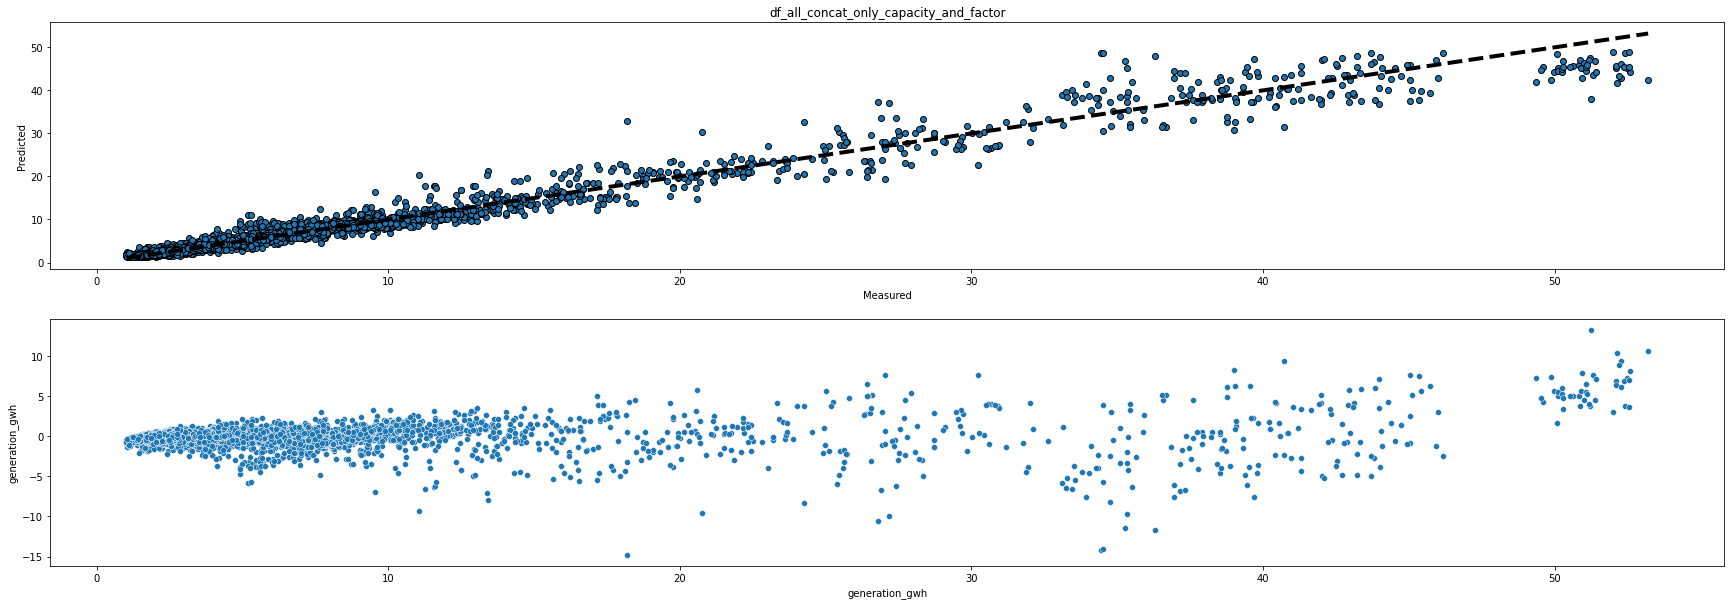

In [71]:

fig, ax =plt.subplots(2, figsize=(30,10))

# for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
# predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y'], cv=5)
predicted = cross_val_predict(rf_model, dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'], cv=5)
# fig, ax = plt.subplots()
ax[0].scatter(dataframes_dict_X_y['df_all_concat_lin_corr']['y'], predicted, edgecolors=(0, 0, 0))
ax[0].plot([dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], [dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], "k--", lw=4)
ax[0].set_xlabel("Measured")
ax[0].set_ylabel("Predicted")
ax[0].set_title(k)
# plt.show()

residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y'] - predicted
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'] = predicted
sns.scatterplot(x=dataframes_dict_X_y['df_all_concat_lin_corr']['y'], y=residuals, ax=ax[1])

In [72]:
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions']

array([ 7.19730936,  9.36221085, 15.40656135, ...,  4.43852861,
        9.21267149,  2.00691352])

In [73]:
quantiles = [0.05, 0.95]
predictions_qr = {}
# dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data']
# dataframes_dict_X_y['df_all_concat_lin_corr']['y']
out_bounds_predictions = np.zeros_like(dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, fit_intercept= False, solver='highs', alpha=0)
    qr.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values)
    dataframes_dict_X_y['df_all_concat_lin_corr'][f'model_qr_{str(quantile)[2:]}_fit'] = qr
    y_pred = qr.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1))
    predictions_qr[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )

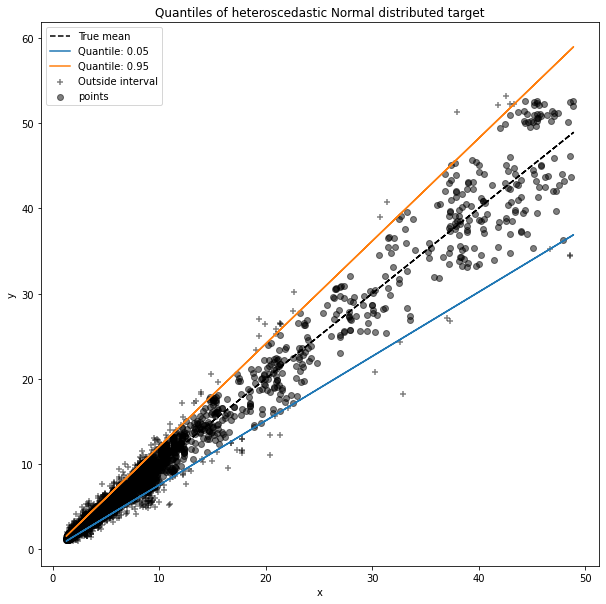

In [74]:
plt.figure(figsize=(10,10))

# dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data']
# dataframes_dict_X_y['df_all_concat_lin_corr']['y']

plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions_qr.items():
    plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][~out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="points",
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [75]:
dataframes_dict_X_y['df_all_concat_lin_corr'].keys()

dict_keys(['X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_tree_size', 'predictions', 'residuals', 'predictions_all_data', 'model_qr_05_fit', 'model_qr_95_fit'])

In [78]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'].predict(np.array([[50]]))

array([37.71673852])

In [79]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'].predict(np.array([[50]]))

array([60.2578451])

In [80]:
out_bounds_predictions.sum()


697

In [82]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() / (dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() + out_bounds_predictions.sum())

0.8843921048266711

In [ ]:
df_mapie['y_test'].values.reshape(-1, 1)

In [ ]:
df_mapie['y_test']

In [ ]:
df_mapie['y_pred'] = y_pred
df_mapie['y_test'] = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].reset_index(drop=True)
df_mapie['y_pis_lower'] = y_pis[:,0,:]
df_mapie['y_pis_upper'] = y_pis[:,1,:]

# EXPORTING THE MODEL

In [84]:
# rf_model = rf_grid.best_estimator_
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'])
joblib.dump(rf_model, utils.DIR_MODELS/"rf_model_regressor.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'], utils.DIR_MODELS/"qr_model_05.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'], utils.DIR_MODELS/"qr_model_95.pkl")


['/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/models/qr_model_95.pkl']

In [ ]:
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train']['capacity_mw'].describe()